In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso, Ridge
from sklearn.model_selection import GridSearchCV
import seaborn as sns

In [2]:
# Load the data
nordpool = pd.read_csv('New Data/2021/Nordpool DKK.csv')
energinet = pd.read_csv('New Data/2021/Energinet DKK.csv')
weather_observation = pd.read_csv('New Data/2021/Weather Observation.csv')
weather_forecast = pd.read_csv('New Data/2021/Weather Forecast.csv')
network = pd.read_csv('New Data/2021/Network Manager.csv')

# Filter energinet price area
energinet = energinet[energinet['PriceArea | PriceArea | 804696'] == 'DK2']
# Drop price area
energinet.drop('PriceArea | PriceArea | 804696', axis=1, inplace=True)

# Convert ts to datetime
nordpool['ts'] = pd.to_datetime(nordpool['ts'])
energinet['ts'] = pd.to_datetime(energinet['ts'])
weather_observation['ts'] = pd.to_datetime(weather_observation['ts'])
weather_forecast['ts'] = pd.to_datetime(weather_forecast['ts'])
network['ts'] = pd.to_datetime(network['ts'])

# Resample network_manager data to hourly intervals (average the data)
network = network.set_index('ts')
network = network.resample('h').mean()
network.reset_index(inplace=True)

## Step 2: Data Handling

In [3]:
# Compare length of dfs + get first & last timestamp
def get_first_last(**dfs):
    # Initialize
    first_last = pd.DataFrame(index=['first', 'last', 'length', 'start_check', 'end_check'])
    col_name='ts'
    # Save first and last timestamp for each dataframe
    for name, df in dfs.items():
        first_ts = df['ts'].iloc[0]
        last_ts = df['ts'].iloc[-1]
        start_check = start == first_ts
        end_check = end == last_ts
        first_last[name] = [first_ts, last_ts, len(df), start_check, end_check]
    return first_last

# Initialize
start = pd.to_datetime('2021-01-01 00:00:00')
end = pd.to_datetime('2021-12-31 23:00:00')

print("Length of a year in hours:", 365*24)
get_first_last(nordpool=nordpool, energinet=energinet, weather_observation=weather_observation, weather_forecast=weather_forecast, network=network)

Length of a year in hours: 8760


,nordpool,energinet,weather_observation,weather_forecast,network
first,2021-01-02 00:00:00,2021-01-01 00:00:00,2021-01-15 16:00:00,2021-01-01 00:00:00,2021-01-01 00:00:00
last,2021-12-31 23:00:00,2021-12-31 23:00:00,2021-12-31 23:00:00,2021-12-29 11:00:00,2021-12-31 23:00:00
length,8735,8759,7936,8694,8760
start_check,False,True,False,True,True
end_check,True,True,True,False,True


### Data Merging

In [4]:
# Merge the dataframes on network with left join
data = pd.merge(network, weather_forecast, on='ts', how='left')
data = pd.merge(data, weather_observation, on='ts', how='left') 

# Sort the data by the timestamp column 'ts' to ensure time order
data21 = data.sort_values(by='ts')

# Save to csv
# data21.to_csv('New Data/2021/Wind Data 21.csv', index=False)

data21.head()

,ts,Hasle Common 10kV Lines Voltage | has_fel_10kvskinnespend | 804133,Hasle Vind Active Power | has_vin_effekt | 804123,Hasle Vind Current | has_vin_belastning | 804117,Weather forecast for the max air temperature for the coming 6 hours at Bornholm | 9F7P/00/00/MET-Norway/forecast/air_temperature_max | 128206,Weather forecast for wind direction at Bornholm | 9F7P/00/00/MET-Norway/forecast/wind_direction | 128270,Weather forecast for the precipitation amount for the coming 1 hour at Bornholm | 9F7P/00/00/MET-Norway/forecast/precipitation_amount_acc | 128238,Weather forecast for the relativehumidity amount at Bornholm | 9F7P/00/00/MET-Norway/forecast/relative_humidity_2m | 128254,Weather forecast for wind speed at Bornholm | 9F7P/00/00/MET-Norway/forecast/wind_speed | 128286,Weather forecast for wind speed y_direction at Bornholm | 9F7P/00/00/MET-Norway/forecast/y_wind_10m | 128318,...,Weather forecast for wind speed x_direction at Bornholm | 9F7P/00/00/MET-Norway/forecast/x_wind_10m | 128302,Weather forecast for the air temperature at Bornholm | 9F7P/00/00/MET-Norway/forecast/air_temperature_2m | 128190,Observed maximum temperature past hour at Hammer Odde Fyr - DMI station 06193 | 9F7P/7Q/XC/DMI/metObs/temp_max_past1h/06193 | 406592,Observed mean intensity of global radiation in the latest hour at Hammer Odde Fyr - DMI station 06193 | 9F7P/7Q/XC/DMI/metObs/radia_glob_past1h/06193 | 406672,Observed minimum temperature past hour at Hammer Odde Fyr - DMI station 06193 | 9F7P/7Q/XC/DMI/metObs/temp_min_past1h/06193 | 406608,Observed mean wind speed the past hour at Hammer Odde Fyr - DMI station 06193 | 9F7P/7Q/XC/DMI/metObs/wind_speed_past1h/06193 | 406640,Observed mean humidity past hour at Hammer Odde Fyr - DMI station 06193 | 9F7P/7Q/XC/DMI/metObs/humidity_past1h/06193 | 406576,Observed mean temperature past hour at Hammer Odde Fyr - DMI station 06193 | 9F7P/7Q/XC/DMI/metObs/temp_mean_past1h/06193 | 406560,Observed mean wind direction the past hour at Hammer Odde Fyr - DMI station 06193 | 9F7P/7Q/XC/DMI/metObs/wind_dir_past1h/06193 | 406624,Observed accumulated precipitation the past hour at Hammer Odde Fyr - DMI station 06193 | 9F7P/7Q/XC/DMI/metObs/precip_past1h/06193 | 406656
0,2021-01-01 00:00:00,10.505372,0.310046,19.138536,275.52020,189.13286,0.000000,0.848557,3.711973,3.658367,...,0.593647,275.51404,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-01-01 01:00:00,10.499852,0.739963,42.792531,275.50630,191.73468,0.269043,0.937904,3.358219,3.176009,...,0.794102,275.36557,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-01-01 02:00:00,10.440138,0.877331,50.523536,275.13600,184.39082,0.167969,0.974747,3.255157,3.315285,...,0.328136,275.08374,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2021-01-01 03:00:00,10.423414,0.842384,47.936477,274.88626,178.39856,0.000000,0.973976,3.109769,3.461883,...,-0.328434,274.86594,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2021-01-01 04:00:00,10.401766,0.469178,28.816449,274.93670,170.38286,0.662842,0.989250,3.090981,3.048118,...,-0.469315,274.80240,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Load merged data from 2022  (neccessary for feature engineering like lags)

In [5]:
# Load csv
data22 = pd.read_csv('New Data/2022/Wind Data 22.csv')

# Concatenate the dataframes
data = pd.concat([data21, data22], join='inner', axis=0, ignore_index=True)

# Ensure datetime format
data['ts'] = pd.to_datetime(data['ts'])

Column cleaning

In [6]:

# Use regex to remove everything starting from '|'
data.columns = data.columns.str.replace(r'\|.*', '', regex=True)
nordpool.columns = nordpool.columns.str.replace(r'\|.*', '', regex=True)
energinet.columns = energinet.columns.str.replace(r'\|.*', '', regex=True)

# Use regex to remove everything starting from the word "at"
data.columns = data.columns.str.replace(r'\sat.*', '', regex=True)
data.columns = data.columns.str.replace(r'Hasle', '', regex=True)
data.columns = data.columns.str.replace(r'Vind', 'Wind', regex=True)

# Strip columns
data.columns = data.columns.str.strip()

data.columns

Index(['ts', 'Common 10kV Lines Voltage', 'Wind Active Power', 'Wind Current',
       'Weather forecast for the max air temperature for the coming 6 hours',
       'Weather forecast for wind direction',
       'Weather forecast for the precipitation amount for the coming 1 hour',
       'Weather forecast for the relativehumidity amount',
       'Weather forecast for wind speed',
       'Weather forecast for wind speed y_direction',
       'Weather forecast for solar shortwave flux',
       'Weather forecast for the minimum air temperature for the coming 6 hours',
       'Weather forecast for wind speed x_direction',
       'Weather forecast for the air temperature',
       'Observed maximum temperature past hour',
       'Observed mean intensity of global radiation in the latest hour',
       'Observed minimum temperature past hour',
       'Observed mean wind speed the past hour',
       'Observed mean humidity past hour',
       'Observed mean temperature past hour',
       'Observed

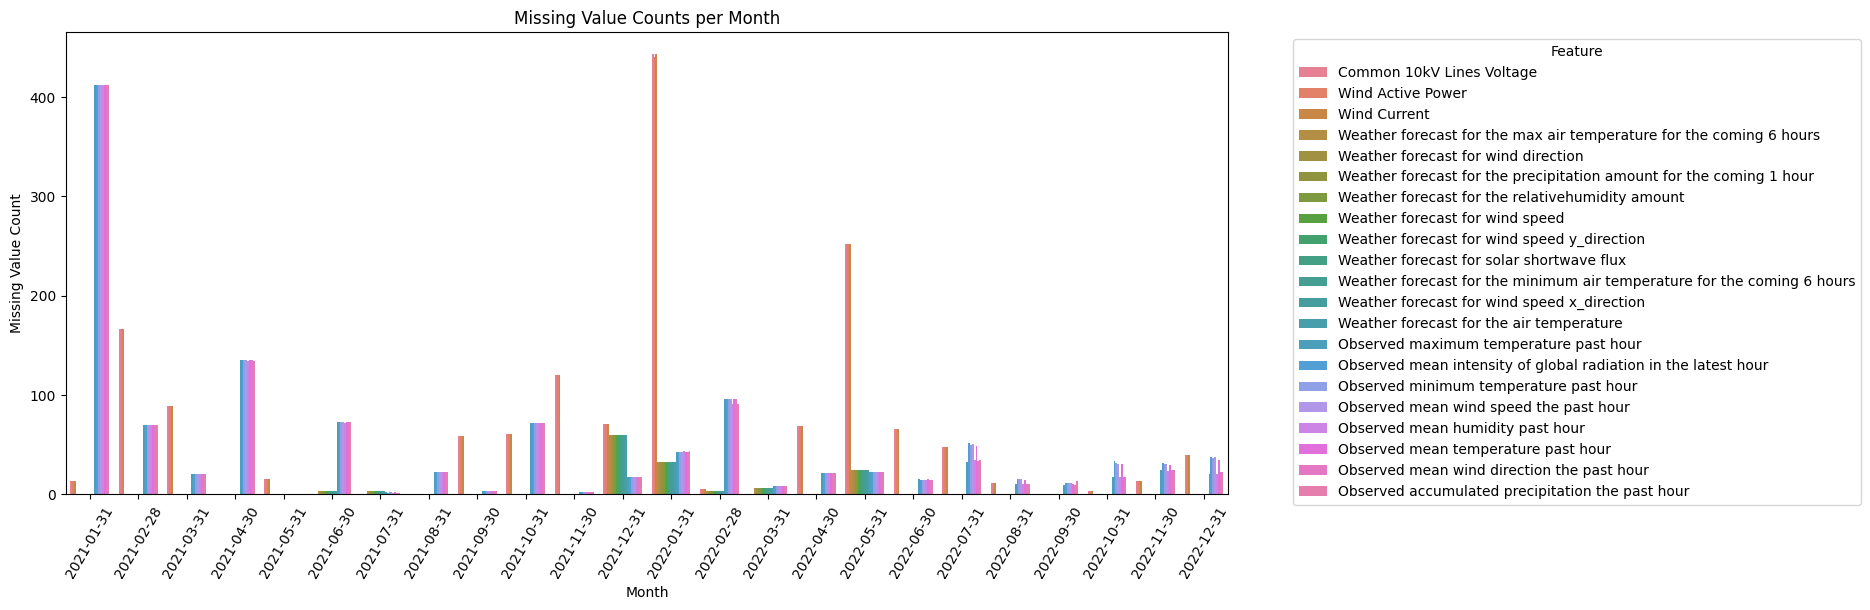

In [7]:
# Resample the data by months ('M') and count missing values for each period
data = data.set_index('ts')
missing_per_month = data.isnull().resample('ME').sum()
# Reset
data = data.reset_index()

# Convert the resampled data into a long-form dataframe for easier plotting with Seaborn
missing_per_month_long = missing_per_month.reset_index().melt(id_vars='ts', var_name='Feature', value_name='Missing Count')

# Create the seaborn barplot
plt.figure(figsize=(15, 6))
sns.barplot(x='ts', y='Missing Count', hue='Feature', data=missing_per_month_long)
plt.xticks(rotation=60)
plt.title('Missing Value Counts per Month')
plt.xlabel('Month')
plt.ylabel('Missing Value Count')
plt.legend(title='Feature', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

### Missing Values Handling

In [8]:
# df_interpolated = data.interpolate(method='linear')

# Set ts as index
missing_before = data.isnull().sum()
data = data.set_index('ts')
# Interpolate missing values (time series-based)
data = data.interpolate(method='time')
# Reset index
data = data.reset_index()
missing_after = data.isnull().sum()

missing_summary = pd.DataFrame({'Before': missing_before, 'After': missing_after})
missing_summary

,Before,After
ts,0,0
Common 10kV Lines Voltage,1544,0
Wind Active Power,1541,0
Wind Current,1544,0
Weather forecast for the max air temperature for the coming 6 hours,132,0
Weather forecast for wind direction,132,0
Weather forecast for the precipitation amount for the coming 1 hour,132,0
Weather forecast for the relativehumidity amount,132,0
Weather forecast for wind speed,132,0
Weather forecast for wind speed y_direction,132,0


Features for Weather observation can not be interpolated as they occur in the very beginning. (01/01/21 - 15/01/21)

### Feature Engineering

- Lagged days
- Quantiles from prev week
- Wind power production is proportional to the cube of the wind speed: $P = \frac{1}{2} \rho \pi r^2 V^3 $
- Time-based features like day and hour


Since 'Observed mean wind speed the past hour' and 'Observed Wind Speed Cubed' are highly correlated, we may encounter multicollinearity which can inflate variance estimates for regression coefficients. 

-> Lasso or Ridge regression or Nonlinear Regression needed?


In [9]:
data = data.rename(columns={'Wind Active Power': 'Wind Power'})

# Shift by 24 hours for daily data
data['Wind Power Lag1'] = data['Wind Power'].shift(24)
data['Wind Power Lag2'] = data['Wind Power'].shift(48)
data['Wind Power Lag3'] = data['Wind Power'].shift(72)

# Rolling average for 1 week (=168h) for several quantiles
data['Wind Power 0.50 Quantile'] = data['Wind Power'].rolling(window=168).quantile(0.5)
data['Wind Power 0.75 Quantile'] = data['Wind Power'].rolling(window=168).quantile(0.75)
data['Wind Power 0.95 Quantile'] = data['Wind Power'].rolling(window=168).quantile(0.95)

# Cube of windspeed? (to capture non-linear relationships or wait for polynomial features?)
data['Observed Wind Speed Cubed'] = data['Observed mean wind speed the past hour']**3
data['Forecasted Wind Speed Cubed'] = data['Weather forecast for wind speed']**3

# Time-based features
data['Day'] = data['ts'].dt.dayofweek
data['Hour'] = data['ts'].dt.hour
data['Month'] = data['ts'].dt.month

Cut down the data as weather_observation starts **15/01/2021** and ends **31/12/2021**?

In [10]:
# Exclude all before 15/01/2021 for data
start = pd.to_datetime('2021-01-15 16:00:00')
data = data[data['ts'] >= start]
# Exclude all after 31/12/2021 for data
data = data[data['ts'] <= end]
# Reset index
data = data.reset_index(drop=True)
# Check success
len(data)

8408

In [11]:
# Check missing values
data.isnull().sum()

ts                                                                         0
Common 10kV Lines Voltage                                                  0
Wind Power                                                                 0
Wind Current                                                               0
Weather forecast for the max air temperature for the coming 6 hours        0
Weather forecast for wind direction                                        0
Weather forecast for the precipitation amount for the coming 1 hour        0
Weather forecast for the relativehumidity amount                           0
Weather forecast for wind speed                                            0
Weather forecast for wind speed y_direction                                0
Weather forecast for solar shortwave flux                                  0
Weather forecast for the minimum air temperature for the coming 6 hours    0
Weather forecast for wind speed x_direction                                0

### Data Visualization

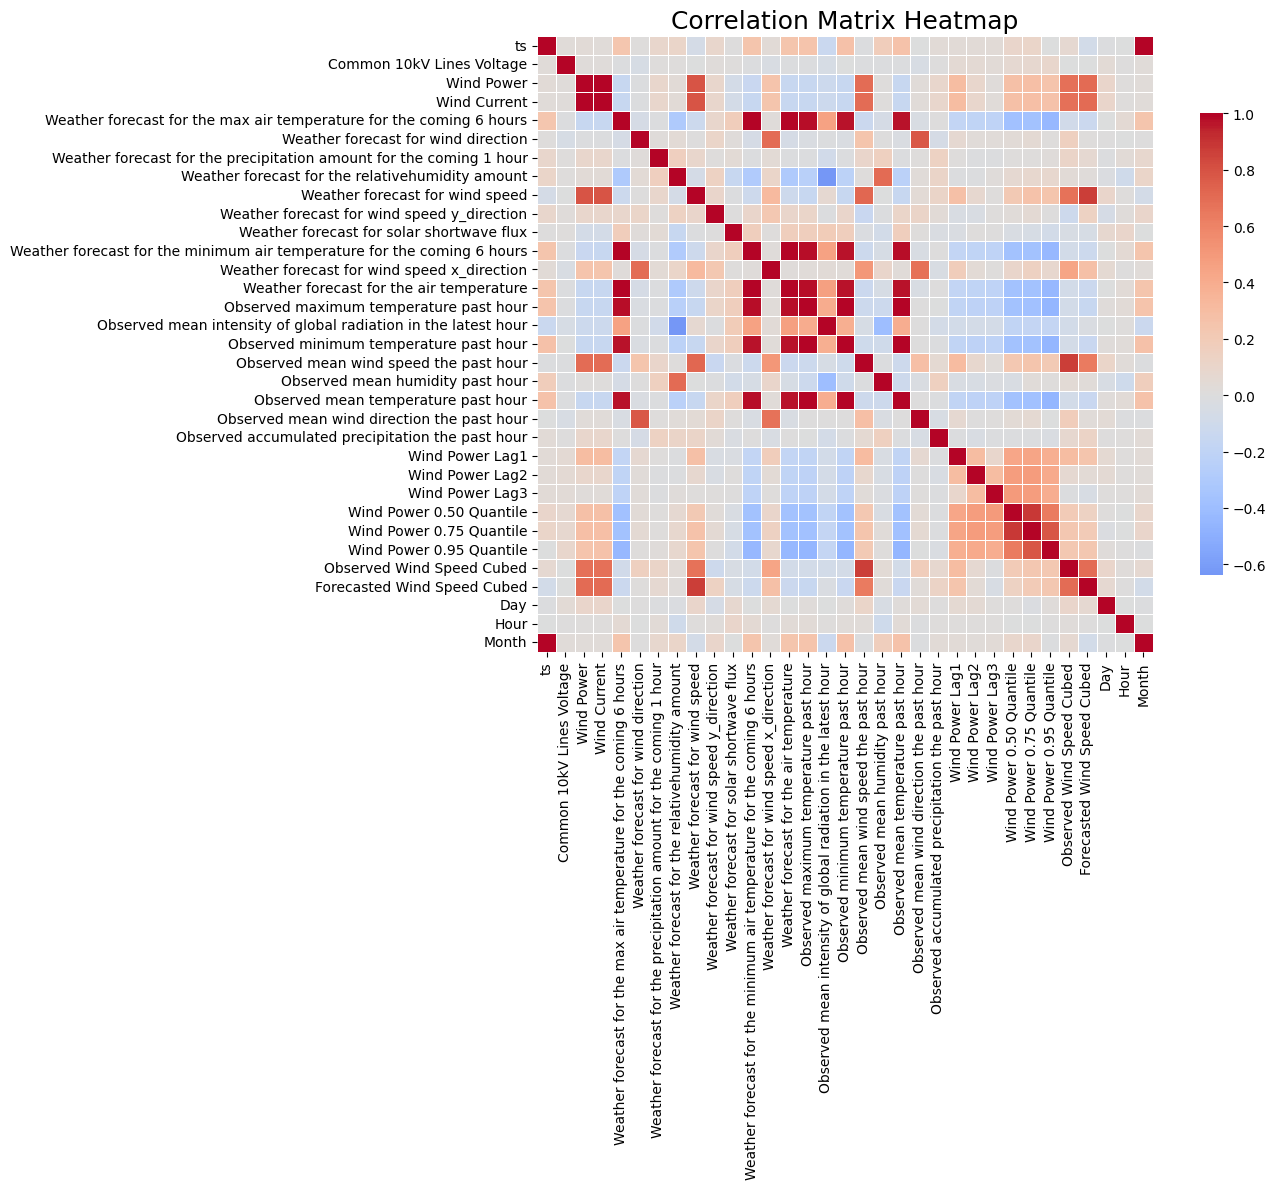

In [12]:
# Correlation matrix between features
corr_matrix = data.corr()
# print(corr_matrix)

plt.figure(figsize=(15, 12))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0, linewidths=0.5, 
            cbar_kws={"shrink": 0.75}, square=True)
plt.title('Correlation Matrix Heatmap', fontsize=18)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()

plt.show()

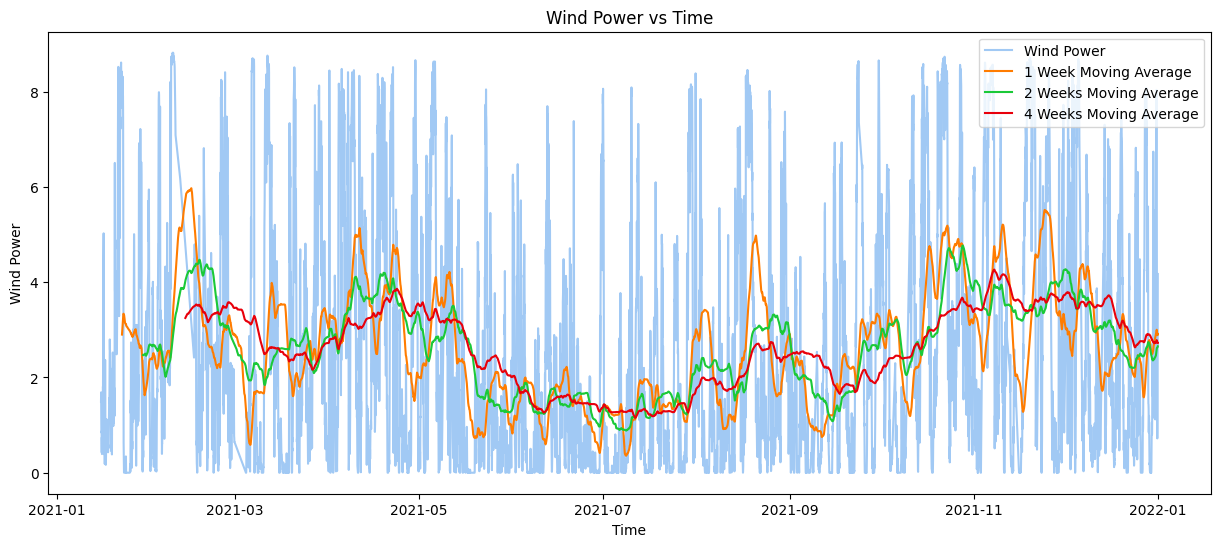

In [13]:
palette1 = sns.color_palette("pastel")
palette2 = sns.color_palette("bright")

# Plot moving average of wind power vs time
plt.figure(figsize=(15, 6))
sns.lineplot(x=data['ts'], y=data['Wind Power'], label='Wind Power', color=palette1[0])
sns.lineplot(x=data['ts'], y=data['Wind Power'].rolling(window=168).mean(), label='1 Week Moving Average', color=palette2[1])
sns.lineplot(x=data['ts'], y=data['Wind Power'].rolling(window=336).mean(), label='2 Weeks Moving Average', color=palette2[2])
sns.lineplot(x=data['ts'], y=data['Wind Power'].rolling(window=672).mean(), label='4 Weeks Moving Average', color=palette2[3])
plt.title('Wind Power vs Time')
plt.xlabel('Time')
plt.ylabel('Wind Power')
plt.legend(loc='upper right')
plt.show()

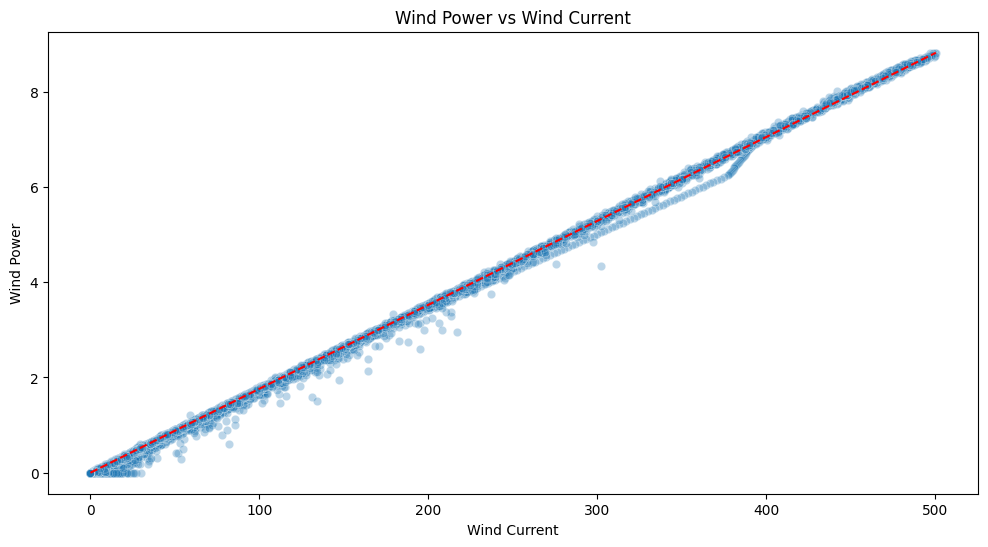

In [14]:
# Plot wind power vs wind current
plt.figure(figsize=(12, 6))
sns.scatterplot(x='Wind Current', y='Wind Power', data=data, alpha=0.3)
plt.plot([0, data['Wind Current'].max()], [0, data['Wind Power'].max()], color='red', linestyle='--')
plt.title('Wind Power vs Wind Current')
plt.xlabel('Wind Current')
plt.ylabel('Wind Power')
plt.show()

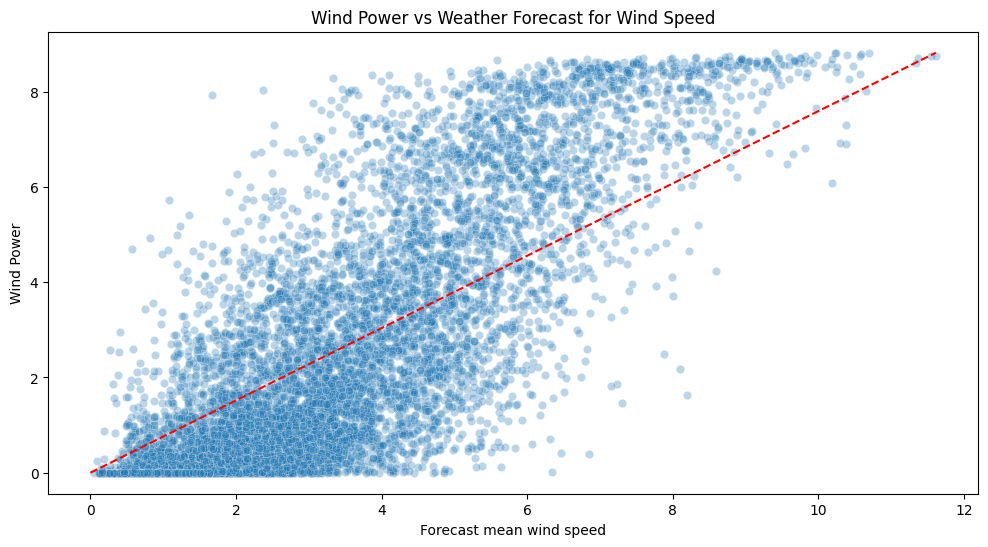

In [15]:
# Plot wind power vs weather forecast for wind speed
plt.figure(figsize=(12, 6))
sns.scatterplot(x='Weather forecast for wind speed', y='Wind Power', data=data, alpha=0.3)
plt.plot([0, data['Weather forecast for wind speed'].max()], [0, data['Wind Power'].max()], color='red', linestyle='--')
plt.title('Wind Power vs Weather Forecast for Wind Speed')
plt.xlabel('Forecast mean wind speed')
plt.ylabel('Wind Power')
plt.show()

### Train-Test Split (80/20) + Feature Selection (Forward Search + Shapley Values)

Split 80/20 train and test

In [81]:
# Define X, y
X = data.drop(columns=['ts', 'Wind Power', 'Wind Current']) # Features
ts = data['ts']
y = data['Wind Power']

# Split 80/20
split_index = int(len(X) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Scale the features using StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert scaled arrays back to DataFrames with original indices and column names
X_train = pd.DataFrame(X_train, index=X.index[:split_index], columns=X.columns)
X_test = pd.DataFrame(X_test, index=X.index[split_index:], columns=X.columns)
y_train = pd.Series(y_train.values, index=y.index[:split_index])
y_test = pd.Series(y_test.values, index=y.index[split_index:])

# Confirm index alignment
print("Train Index Equality:", X_train.index.equals(y_train.index))
print("Test Index Equality:", X_test.index.equals(y_test.index))

# Print shapes of the resulting datasets
print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

Train Index Equality: True
Test Index Equality: True
Training data shape: (6726, 30)
Testing data shape: (1682, 30)


In [114]:
import shap

# Forward search
def forward_search(X_train, y_train, X_test, y_test):
    selected_features = []
    remaining_features = list(X_train.columns)
    best_mse = float('inf')

    while remaining_features:
        performance = {}

        for feature in remaining_features:
            features_to_test = selected_features + [feature]
            model = LinearRegression()
            model.fit(X_train[features_to_test], y_train)
            y_pred = model.predict(X_test[features_to_test])
            mse = mean_squared_error(y_test, y_pred)
            performance[feature] = mse

        # Select the best-performing feature (lowest MSE)
        best_feature = min(performance, key=performance.get)
        if performance[best_feature] < best_mse:
            best_mse = performance[best_feature]
            selected_features.append(best_feature)
            remaining_features.remove(best_feature)
        else:
            break

    return selected_features, best_mse

# Run forward search
top_features_FS, best_mse = forward_search(X_train, y_train, X_test, y_test)
print("# of Selected Features:", len(top_features_FS))

# Fit Linear Regression model
model = LinearRegression()
model.fit(X, y)

# Compute SHAP values
explainer = shap.Explainer(model, X)
shap_values = explainer(X)

# Calculate mean absolute Shapley values for each feature
shap_feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': np.abs(shap_values.values).mean(axis=0)
}).sort_values(by='importance', ascending=False)

# Set a threshold for feature selection
threshold = shap_feature_importance['importance'].max() * 0.2 

# Select top features based on Shapley values
top_features_SHAP = shap_feature_importance[shap_feature_importance['importance'] >= threshold]
print("# of Selected Features:", len(top_features_SHAP))

# Convert to sets for easier union operation
top_features_FS_set = set(top_features_FS)  # Features from forward search
top_features_SHAP_set = set(top_features_SHAP['feature'].tolist())

# Combine the selected features from both methods
all_features = list(top_features_FS_set | top_features_SHAP_set)

# Create a DataFrame with boolean indicators for each feature's selection status in both methods
feature_selection_df = pd.DataFrame(index=all_features, columns=['Forward Search', 'Shapley Values'])
feature_selection_df['Forward Search'] = feature_selection_df.index.isin(top_features_FS_set)
feature_selection_df['Shapley Values'] = feature_selection_df.index.isin(top_features_SHAP_set)
feature_selection_df['Union'] = feature_selection_df['Forward Search'] & feature_selection_df['Shapley Values']
print("Union of both Selections:", feature_selection_df['Union'].sum())
print("Intersection of both Selections:", len(feature_selection_df))

# Display the result
feature_selection_df

# of Selected Features: 11
# of Selected Features: 8
Union of both Selections: 4
Intersection of both Selections: 15


,Forward Search,Shapley Values,Union
Weather forecast for wind speed x_direction,True,False,False
Observed mean intensity of global radiation in the latest hour,True,True,True
Weather forecast for the relativehumidity amount,True,False,False
Observed mean temperature past hour,False,True,False
Weather forecast for the precipitation amount for the coming 1 hour,True,False,False
Weather forecast for the max air temperature for the coming 6 hours,False,True,False
Weather forecast for the minimum air temperature for the coming 6 hours,False,True,False
Month,True,False,False
Observed minimum temperature past hour,False,True,False
Weather forecast for wind speed,True,True,True


Run Linear Regression with both feature selection for comparison & decision

In [115]:
# Run linear regression with selected features FS
model_FS = LinearRegression()
model_FS.fit(X_train[top_features_FS], y_train)
y_pred_FS = model_FS.predict(X_test[top_features_FS])

# Evaluation metrics
mse_FS = mean_squared_error(y_test, y_pred_FS)
mae_FS = mean_absolute_error(y_test, y_pred_FS)
r2_FS = r2_score(y_test, y_pred_FS)

print("MSE (Forward Search):", mse_FS)
print("MAE (Forward Search):", mae_FS)
print("R^2 (Forward Search):", r2_FS)

# Run linear regression with selected features SHAP
model_SHAP = LinearRegression()
model_SHAP.fit(X_train[top_features_SHAP['feature']], y_train)
y_pred_SHAP = model_SHAP.predict(X_test[top_features_SHAP['feature']])

# Evaluation metrics
mse_SHAP = mean_squared_error(y_test, y_pred_SHAP)
mae_SHAP = mean_absolute_error(y_test, y_pred_SHAP)
r2_SHAP = r2_score(y_test, y_pred_SHAP)

print("MSE (SHAP):", mse_SHAP)
print("MAE (SHAP):", mae_SHAP)
print("R^2 (SHAP):", r2_SHAP)

MSE (Forward Search): 1.957545174340071
MAE (Forward Search): 1.1079637559462878
R^2 (Forward Search): 0.7204799488944765
MSE (SHAP): 2.128290110837572
MAE (SHAP): 1.1252806217783498
R^2 (SHAP): 0.6960990896420813


In [117]:
# Define new X (with selected features forward search)
X = data[top_features_FS]

# Split 80/20
split_index = int(len(X) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Scale the features using StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert scaled arrays back to DataFrames with original indices and column names
X_train = pd.DataFrame(X_train, index=X.index[:split_index], columns=X.columns)
X_test = pd.DataFrame(X_test, index=X.index[split_index:], columns=X.columns)
y_train = pd.Series(y_train.values, index=y.index[:split_index])
y_test = pd.Series(y_test.values, index=y.index[split_index:])

# Confirm index alignment
print("Train Index Equality:", X_train.index.equals(y_train.index))
print("Test Index Equality:", X_test.index.equals(y_test.index))

# Print shapes of the resulting datasets
print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

Train Index Equality: True
Test Index Equality: True
Training data shape: (6726, 11)
Testing data shape: (1682, 11)


## Step 3: Linear Regression

### Step 3.1: Linear Regression (small sample)

Implementation of both approaches

In [118]:
# Step 3.1: Gradient Descent
class LinearRegressionGD:

    # attributes of the class
    def __init__(self, learning_rate=0.01, n_iterations=1000): 
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.theta = None  # Parameter vector (weights and bias)
        self.cost_history = []  # To store cost function values over iterations
    
    # gradient descent algorithm
    def fit(self, X, y): 
        # Ensure that X and y are NumPy arrays and convert them to float type
        X = np.array(X, dtype=float)
        y = np.array(y, dtype=float)

        # Number of training samples (m) and number of features (n)
        m, n = X.shape

        # Add a bias (intercept) column of ones to the input matrix X
        X_b = np.c_[np.ones((m, 1)), X]  # X_b is now (m, n+1) with the bias term
        
        # Initialize theta (parameters) with zeros
        self.theta = np.zeros(n + 1)  # Including bias
        
        # Gradient Descent loop
        for _ in range(self.n_iterations):
            # Predicted values (y_hat = X_b * theta)
            y_pred = X_b.dot(self.theta)
            
            # Compute cost (MSE)
            cost = (1 / (2 * m)) * np.sum((y_pred - y) ** 2)
            self.cost_history.append(cost)  # Store cost for plotting

            # Gradient (in matrix form)
            gradient = (1 / m) * X_b.T.dot(y_pred - y)
            
            # Update the parameters theta
            self.theta -= self.learning_rate * gradient
    
    # prediction function
    def predict(self, X):
        # Ensure that X is a NumPy array and convert it to float type
        X = np.array(X, dtype=float)
        
        # Add a bias (intercept) column of ones to the input matrix X
        X_b = np.c_[np.ones((X.shape[0], 1)), X]
        
        # Return predictions (y_pred = X_b * theta)
        return X_b.dot(self.theta)

################################################################################################################################################

# Step 3.1: Closed-form solution (Normal Equation)
def ClosedFormSolution(X, y):
    # Ensure that X and y are NumPy arrays and convert them to float type
    X = np.array(X, dtype=float)
    y = np.array(y, dtype=float)
    
    # Add a bias (intercept) column of ones to the input matrix X
    X_b = np.c_[np.ones((X.shape[0], 1)), X]
    
    # Normal equation: theta = (X.T * X)^(-1) * X.T * y
    theta_best = np.linalg.pinv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)
    
    return theta_best

Test of both approaches on small sample (e.g. 200 rows)

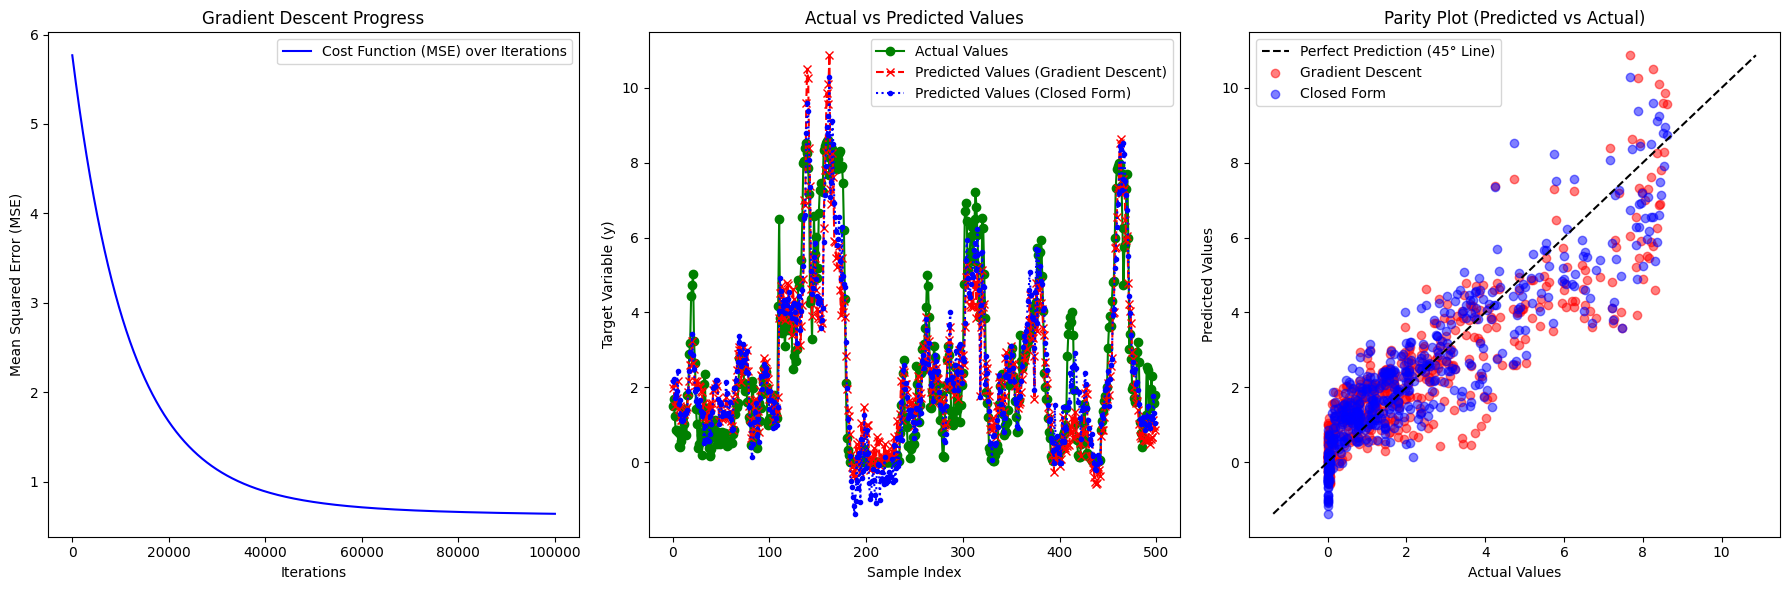

Gradient Descent Coefficients: [ 0.52497178  0.68655762  0.40164372 -0.34014257 -0.83987116  0.56974426
  0.13139358  0.08989144  0.58816865  0.0333647   0.12049834  0.04608311]
Closed-Form Solution Coefficients: [ 3.30382176  1.06523616  0.85339455 -1.93743463  1.28303039  0.40781246
  0.22628002  0.38772315  0.13569574 -0.3608962   0.00972443  0.12409608]


In [141]:
# Small subset of train data
X_train_small = np.array(X_train[:500], dtype=float)  
y_train_small = np.array(y_train[:500], dtype=float)

# Train using Gradient Descent
gd_model = LinearRegressionGD(learning_rate=0.00001, n_iterations=100000)
gd_model.fit(X_train_small, y_train_small)
y_pred_gd = gd_model.predict(X_train_small)

# Train using Closed-Form Solution (Normal Equation)
theta_best = ClosedFormSolution(X_train_small, y_train_small)
X_b_small = np.c_[np.ones((X_train_small.shape[0], 1)), X_train_small]
y_pred_closed_form = X_b_small.dot(theta_best)

# Create a figure with three subplots: Gradient Descent progress, Actual vs. Predicted, Parity plot
fig, axs = plt.subplots(1, 3, figsize=(18, 6)) 

# Subplot 1: Cost function over iterations (for Gradient Descent)
axs[0].plot(gd_model.cost_history, label='Cost Function (MSE) over Iterations', color='b')
axs[0].set_xlabel('Iterations')
axs[0].set_ylabel('Mean Squared Error (MSE)')
axs[0].set_title('Gradient Descent Progress')
axs[0].legend()

# Subplot 2: Actual vs Predicted values for both methods
axs[1].plot(y_train_small, label='Actual Values', marker='o', color='g')
axs[1].plot(y_pred_gd, label='Predicted Values (Gradient Descent)', marker='x', linestyle='--', color='r')
axs[1].plot(y_pred_closed_form, label='Predicted Values (Closed Form)', marker='.', linestyle=':', color='b')
axs[1].set_xlabel('Sample Index')
axs[1].set_ylabel('Target Variable (y)')
axs[1].set_title('Actual vs Predicted Values')
axs[1].legend()

# Subplot 3: Parity plot for both methods (Predicted vs Actual with 45-degree line)
min_val = min(y_train_small.min(), y_pred_gd.min(), y_pred_closed_form.min())
max_val = max(y_train_small.max(), y_pred_gd.max(), y_pred_closed_form.max())

# Add the 45-degree perfect prediction line
axs[2].plot([min_val, max_val], [min_val, max_val], 'k--', label='Perfect Prediction (45° Line)')
axs[2].scatter(y_train_small, y_pred_gd, label='Gradient Descent', color='r', alpha=0.5)
axs[2].scatter(y_train_small, y_pred_closed_form, label='Closed Form', color='b', alpha=0.5)

axs[2].set_xlabel('Actual Values')
axs[2].set_ylabel('Predicted Values')
axs[2].set_title('Parity Plot (Predicted vs Actual)')
axs[2].legend()

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

# Verify that both solutions are close by comparing the predictions
print("Gradient Descent Coefficients:", gd_model.theta)
print("Closed-Form Solution Coefficients:", theta_best)
# print("Are the predictions close? ", np.allclose(y_pred_gd, y_pred_closed_form, atol=1e-1))

In [144]:
from sklearn.linear_model import SGDRegressor

# Initialize and fit the SGD Regressor
sgd_regressor = SGDRegressor(max_iter=10000, tol=0.001, learning_rate='optimal')
sgd_regressor.fit(X_train_small, y_train_small)

# Predictions and evaluation
y_sdg = sgd_regressor.predict(X_train_small)
mse_sgd = mean_squared_error(y_train_small, y_sdg)
r2_sgd = r2_score(y_train_small, y_sdg)
print("MSE (SGD):", mse_sgd)
print("R^2 (SGD):", r2_sgd)

# Fit the Linear Regression model using closed-form
cf_regressor = LinearRegression(fit_intercept=True)
cf_regressor.fit(X_train_small, y_train_small)

# Predictions and evaluation
y_cf = cf_regressor.predict(X_train_small)
mse_cf = mean_squared_error(y_train_small, y_cf)
r2_cf = r2_score(y_train_small, y_cf)
print("MSE (Closed-Form):", mse_cf)
print("R^2 (Closed-Form):", r2_cf)

# Compare coefficients
print("SGD Coefficients:", sgd_regressor.coef_)
print("Closed-Form Coefficients:", cf_regressor.coef_)
print("Are the coefficients close? ", np.allclose(sgd_regressor.coef_, cf_regressor.coef_, atol=1e-0))


MSE (SGD): 1.8448637602330002e+23
R^2 (SGD): -3.260492352195169e+22
MSE (Closed-Form): 1.044264462746265
R^2 (Closed-Form): 0.8154434832616921
SGD Coefficients: [ 9.58222930e+10 -2.65229637e+10 -2.26925556e+10  9.72870948e+10
 -2.68955708e+10  2.72666363e+11 -5.26997414e+10 -1.33552687e+11
 -4.61903233e+10 -8.83993706e+10  2.44097456e+11]
Closed-Form Coefficients: [ 1.06523616  0.85339455 -1.93743463  1.28303039  0.40781246  0.22628002
  0.38772315  0.13569574 -0.3608962   0.00972443  0.12409608]
Are the coefficients close?  False


### Step 3.2: Linear Regression (large sample)

In [145]:
# Closed-Form Solution (Normal Equation)
theta_best_full = ClosedFormSolution(X_train, y_train) # Compute on the train data
X_b_full = np.c_[np.ones((X_test.shape[0], 1)), X_test] # Predictions on the test / unseen data!
y_test_pred_closed_form = X_b_full.dot(theta_best_full)

# Train using Gradient Descent on full dataset
gd_model = LinearRegressionGD(learning_rate=0.00005, n_iterations=100000)  
gd_model.fit(X_train, y_train) # Compute on the train data
y_test_pred_gd = gd_model.predict(X_test) # Predictions on the test / unseen data!

# Convert predictions to pandas Series with y_test's original index
y_test_pred_closed_form = pd.Series(y_test_pred_closed_form, index=y_test.index)
y_test_pred_gd = pd.Series(y_test_pred_gd, index=y_test.index)

KeyboardInterrupt: 

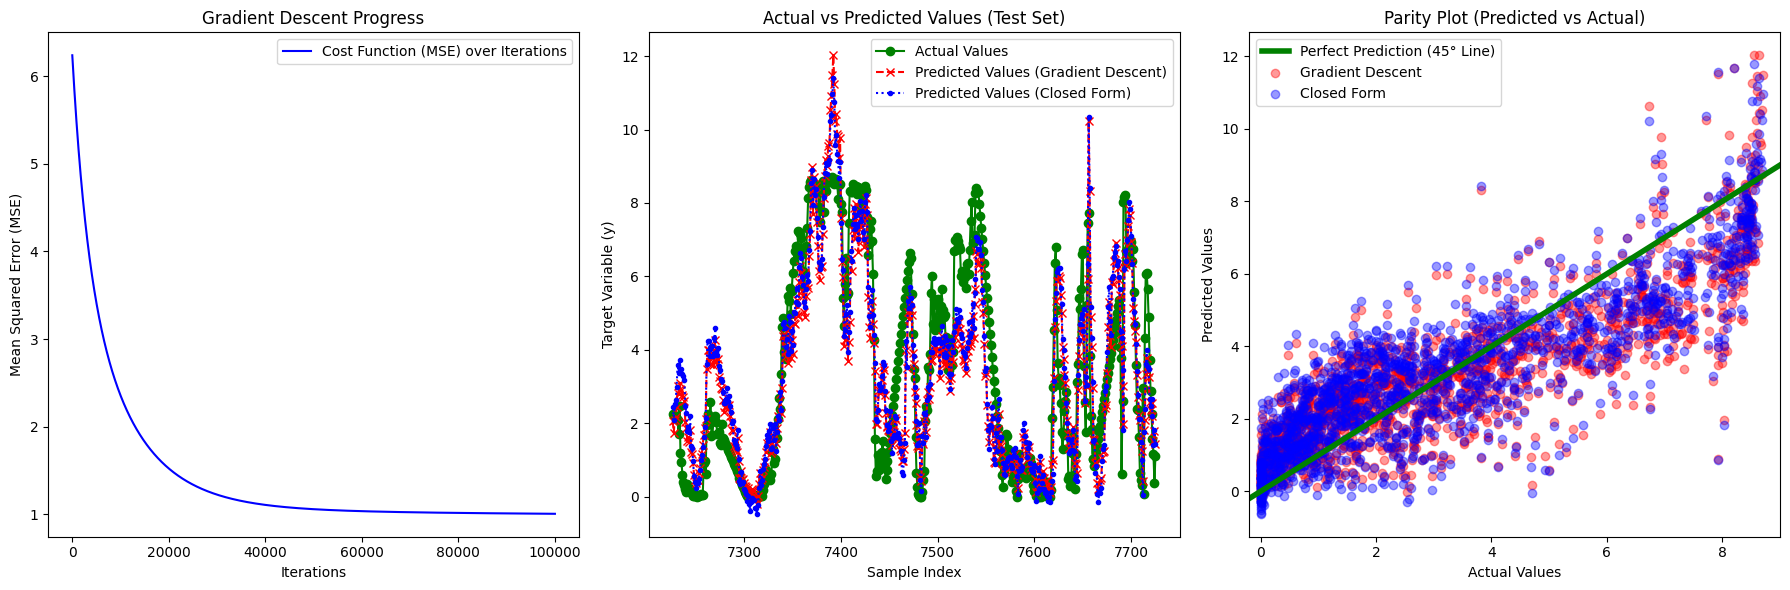

Gradient Descent Coefficients: [ 2.45299933e+00  1.10729812e+00  3.97567407e-01 -2.79453877e-01
  7.73807159e-02  5.46539247e-01  2.37446427e-01 -3.30630244e-01
  3.19698700e-01 -1.16710673e-02 -5.15165047e-04 -3.69718401e-02]
Closed-Form Solution Coefficients: [ 2.46963754e+00  1.67411452e+00  5.32793635e-01 -3.45993504e-01
  9.17201668e-02  3.70074972e-01  2.67097710e-01 -3.49676475e-01
 -2.04678337e-01 -4.34095907e-04 -2.63844390e-02 -5.30762537e-02]
Are the predictions close?  False


In [122]:
# Create a figure with three subplots side by side
fig, axs = plt.subplots(1, 3, figsize=(18, 6))  # 1 row, 3 columns

# Subplot 1: Cost function over iterations (for Gradient Descent)
axs[0].plot(gd_model.cost_history, label='Cost Function (MSE) over Iterations', color='b')
axs[0].set_xlabel('Iterations')
axs[0].set_ylabel('Mean Squared Error (MSE)')
axs[0].set_title('Gradient Descent Progress')
axs[0].legend()

# Subplot 2: Actual vs Predicted values for both methods
axs[1].plot(y_test[500:1000], label='Actual Values', marker='o', color='g')
axs[1].plot(y_test_pred_gd[500:1000], label='Predicted Values (Gradient Descent)', marker='x', linestyle='--', color='r')
axs[1].plot(y_test_pred_closed_form[500:1000], label='Predicted Values (Closed Form)', marker='.', linestyle=':', color='b')
axs[1].set_xlabel('Sample Index')
axs[1].set_ylabel('Target Variable (y)')
axs[1].set_title('Actual vs Predicted Values (Test Set)')
axs[1].legend()

# Subplot 3: Parity plot for both methods (Predicted vs Actual with 45-degree line)
min_val = min(y_test.min(), y_test_pred_gd.min(), y_test_pred_closed_form.min())
max_val = max(y_test.max(), y_test_pred_gd.max(), y_test_pred_closed_form.max())

# Add the 45-degree perfect prediction line
axs[2].plot([min_val, max_val], [min_val, max_val], label='Perfect Prediction (45° Line)', linestyle='-', linewidth=4 ,color='g')
# Scatter plot for Gradient Descent predictions
axs[2].scatter(y_test, y_test_pred_gd, label='Gradient Descent', color='r', alpha=0.4)
# Scatter plot for Closed-Form predictions
axs[2].scatter(y_test, y_test_pred_closed_form, label='Closed Form', color='b', alpha=0.4)

axs[2].set_xlim(-0.2,9)
axs[2].set_xlabel('Actual Values')
axs[2].set_ylabel('Predicted Values')
axs[2].set_title('Parity Plot (Predicted vs Actual)')
axs[2].legend()

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

# Output the coefficients for both methods
print("Gradient Descent Coefficients:", gd_model.theta)
print("Closed-Form Solution Coefficients:", theta_best_full)

# Compare the predictions and check if they are close
print("Are the predictions close? ", np.allclose(y_test_pred_gd, y_test_pred_closed_form))

In [123]:
# Step 3.3: Evaluate the models 
rmse_gd = np.sqrt(mean_squared_error(y_test, y_test_pred_gd))
r2_gd = r2_score(y_test, y_test_pred_gd)
print(f'Mean Squared Error (Gradient Descent): {rmse_gd}')
print(f'R-squared (Gradient Descent): {r2_gd}')

rmse_closed_form = np.sqrt(mean_squared_error(y_test, y_test_pred_closed_form))
r2_closed_form = r2_score(y_test, y_test_pred_closed_form)
print(f'Mean Squared Error (Closed Form): {rmse_closed_form}')
print(f'R-squared (Closed Form): {r2_closed_form}')


Mean Squared Error (Gradient Descent): 1.410423996112557
R-squared (Gradient Descent): 0.7159462347984566
Mean Squared Error (Closed Form): 1.3991230018622627
R-squared (Closed Form): 0.7204799488944769


In [140]:
# Get coefficients from the Linear Regression model
cols = ['Intercept'] + list(X_train.columns)
lr_coefficients_df = pd.DataFrame({ 'Feature': cols, 'Coefficient (GD)': gd_model.theta, 'Coefficient (Closed Form)': theta_best_full})
lr_coefficients_df.T

,0,1,2,3,4,5,6,7,8,9,10,11
Feature,Intercept,Weather forecast for wind speed,Observed Wind Speed Cubed,Observed mean intensity of global radiation in...,Month,Observed mean wind speed the past hour,Weather forecast for wind speed y_direction,Weather forecast for wind speed x_direction,Forecasted Wind Speed Cubed,Weather forecast for the relativehumidity amount,Weather forecast for the precipitation amount ...,Observed accumulated precipitation the past hour
Coefficient (GD),0.512226,0.656413,0.376954,-0.329065,-0.824892,0.538413,0.135964,0.080661,0.582257,0.054445,0.141834,0.045165
Coefficient (Closed Form),2.469638,1.674115,0.532794,-0.345994,0.09172,0.370075,0.267098,-0.349676,-0.204678,-0.000434,-0.026384,-0.053076


## Step 4: Non-linear Regression

Step 4.1: Non-linear Regression through feature modification

Step 4.2: Non-linear Regression through weight modification

In [146]:
# 4.1: Create polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Train the regression model on polynomial features
model_poly = LinearRegression()
model_poly.fit(X_train_poly, y_train)
y_pred_poly = model_poly.predict(X_test_poly)

################################################################################################################################################

# Step 4.2: Define random weights and fit the weighted linear regression model
weights = np.random.rand(X_train.shape[0])  # Random weights for demonstration -> how to set up 

# Train the regression model with specified weights
model_weighted = LinearRegression()
model_weighted.fit(X_train, y_train, sample_weight=weights)
y_pred_weighted = model_weighted.predict(X_test)

Step 4.3: Evaluation of the models with R^2 & RMSE

In [147]:
# Step 4.3: Evaluation metrics for all models
rmse_linear = np.sqrt(mean_squared_error(y_test, y_test_pred_gd))
r2_linear = r2_score(y_test, y_test_pred_gd)
rmse_poly = np.sqrt(mean_squared_error(y_test, y_pred_poly))
r2_poly = r2_score(y_test, y_pred_poly)
rmse_weighted = np.sqrt(mean_squared_error(y_test, y_pred_weighted))
r2_weighted = r2_score(y_test, y_pred_weighted)

# Print the evaluation metrics
print(f"Linear Model R-Squared: {r2_linear}")
print(f"Polynomial Model R-Squared: {r2_poly}")
print(f"Weighted Model R-Squared: {r2_weighted}")

# Convert predictions to pandas Series with y_test's original index
y_pred_poly = pd.Series(y_pred_poly, index=y_test.index)
y_pred_weighted = pd.Series(y_pred_weighted, index=y_test.index)

Linear Model R-Squared: 0.7159462347984566
Polynomial Model R-Squared: 0.724781433214176
Weighted Model R-Squared: 0.720285884184978


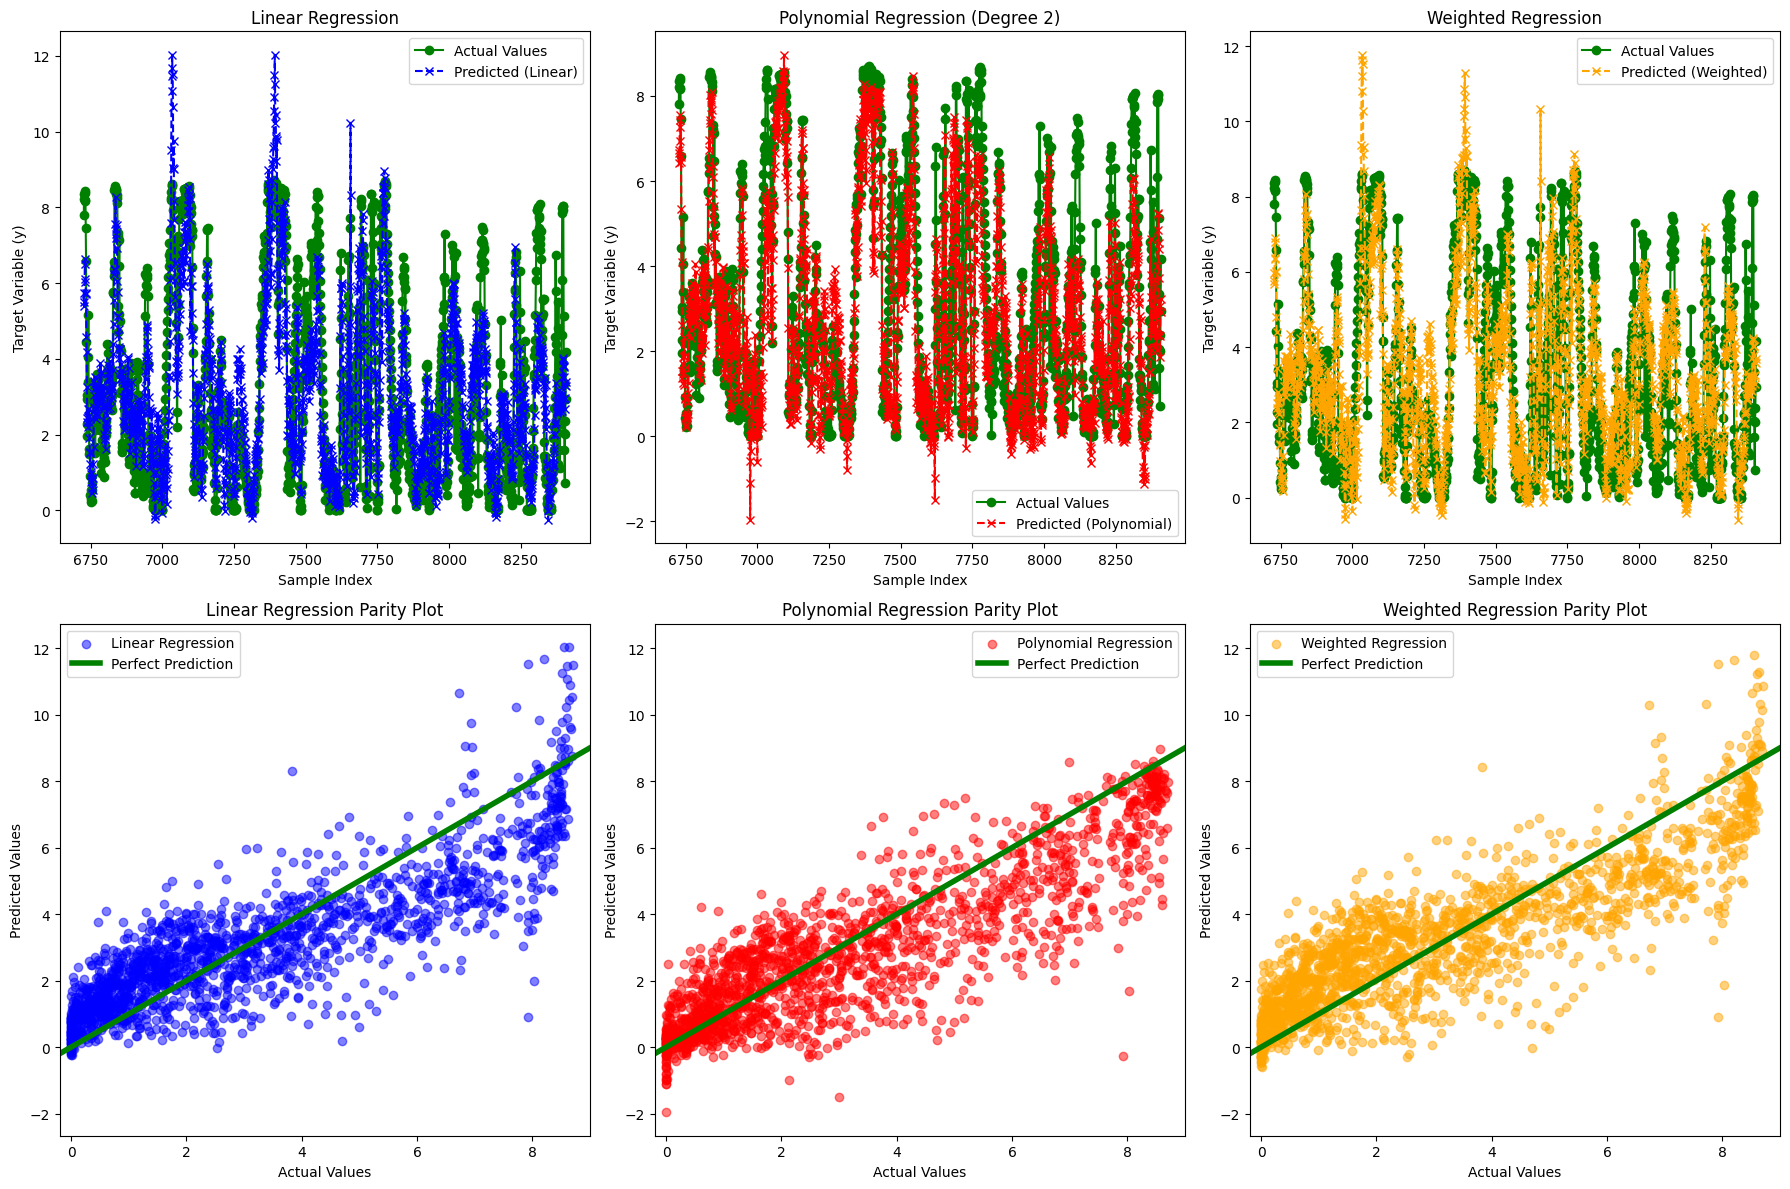

In [148]:
# Create a figure with six subplots (3x2): One row for actual vs. predicted, another for parity plots
fig, axs = plt.subplots(2, 3, figsize=(18, 12))  # 2 rows, 3 columns

### First row: Actual vs. Predicted values
# Subplot 1: Actual vs Predicted for Linear Regression (from Step 3)
axs[0, 0].plot(y_test, label='Actual Values', marker='o', color='g')
axs[0, 0].plot(y_test_pred_gd, label='Predicted (Linear)', marker='x', linestyle='--', color='b')
axs[0, 0].set_xlabel('Sample Index')
axs[0, 0].set_ylabel('Target Variable (y)')
axs[0, 0].set_title('Linear Regression')
axs[0, 0].legend()

# Subplot 2: Actual vs Predicted for Polynomial Regression (Step 4.1)
axs[0, 1].plot(y_test, label='Actual Values', marker='o', color='g')
axs[0, 1].plot(y_pred_poly, label='Predicted (Polynomial)', marker='x', linestyle='--', color='r')
axs[0, 1].set_xlabel('Sample Index')
axs[0, 1].set_ylabel('Target Variable (y)')
axs[0, 1].set_title('Polynomial Regression (Degree 2)')
axs[0, 1].legend()

# Subplot 3: Actual vs Predicted for Weighted Regression (Step 4.2)
axs[0, 2].plot(y_test, label='Actual Values', marker='o', color='g')
axs[0, 2].plot(y_pred_weighted, label='Predicted (Weighted)', marker='x', linestyle='--', color='orange')
axs[0, 2].set_xlabel('Sample Index')
axs[0, 2].set_ylabel('Target Variable (y)')
axs[0, 2].set_title('Weighted Regression')
axs[0, 2].legend()

### Second row: Parity plots (Predicted vs Actual, with 45-degree line)
min_val = min(y_test.min(), y_test_pred_gd.min(), y_pred_poly.min(), y_pred_weighted.min())
max_val = max(y_test.max(), y_test_pred_gd.max(), y_pred_poly.max(), y_pred_weighted.max())

# Subplot 4: Parity plot for Linear Regression
axs[1, 0].scatter(y_test, y_test_pred_gd, color='b', alpha=0.5, label='Linear Regression')
# axs[1, 0].plot([min_val, max_val], [min_val, max_val], 'k--', label='Perfect Prediction')
axs[1, 0].plot([min_val, max_val], [min_val, max_val], label='Perfect Prediction', linestyle='-', linewidth=4 ,color='g')
axs[1, 0].set_xlabel('Actual Values')
axs[1, 0].set_ylabel('Predicted Values')
axs[1, 0].set_title('Linear Regression Parity Plot')
axs[1, 0].set_xlim(-0.2,9)
axs[1, 0].legend()

# Subplot 5: Parity plot for Polynomial Regression
axs[1, 1].scatter(y_test, y_pred_poly, color='r', alpha=0.5, label='Polynomial Regression')
# axs[1, 1].plot([min_val, max_val], [min_val, max_val], 'k--', label='Perfect Prediction')
axs[1, 1].plot([min_val, max_val], [min_val, max_val], label='Perfect Prediction', linestyle='-', linewidth=4 ,color='g')
axs[1, 1].set_xlabel('Actual Values')
axs[1, 1].set_ylabel('Predicted Values')
axs[1, 1].set_title('Polynomial Regression Parity Plot')
axs[1, 1].set_xlim(-0.2,9)
axs[1, 1].legend()

# Subplot 6: Parity plot for Weighted Regression
axs[1, 2].scatter(y_test, y_pred_weighted, color='orange', alpha=0.5, label='Weighted Regression')
# axs[1, 2].plot([min_val, max_val], [min_val, max_val], 'k--', label='Perfect Prediction')
axs[1, 2].plot([min_val, max_val], [min_val, max_val], label='Perfect Prediction', linestyle='-', linewidth=4 ,color='g')
axs[1, 2].set_xlabel('Actual Values')
axs[1, 2].set_ylabel('Predicted Values')
axs[1, 2].set_title('Weighted Regression Parity Plot')
axs[1, 2].set_xlim(-0.2,9)
axs[1, 2].legend()

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


## Step 5: Lasso + Ridge Regression

### Linear: Lasso + Ridge

**Lasso** with Cross-Validation to select optimal alpha value

In [197]:
# Define a range of alpha values to test
alpha_values = np.logspace(-4, 4, num=100)

# Set up the Lasso model with CV
lasso_CV = Lasso()
param_grid = {'alpha': alpha_values}
grid_search = GridSearchCV(estimator=lasso_CV, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Get the best alpha
best_alpha = grid_search.best_params_['alpha']
print(f"Optimal Alpha: {best_alpha}")

Optimal Alpha: 0.03853528593710531


Lasso with optimal alpha

In [198]:
# Lasso Model
lasso = Lasso(alpha=best_alpha) # 0.03853528593710531
lasso.fit(X_train, y_train)
y_pred_lasso = lasso.predict(X_test)

# Evaluate Lasso model
rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
r2_lasso = r2_score(y_test, y_pred_lasso)
print(f"Root Mean Squared Error (RMSE): {rmse_lasso}")
print(f"R-squared (R²): {r2_lasso}")

# Convert predictions to pandas Series with y_test's original index
y_pred_lasso = pd.Series(y_pred_lasso, index=y_test.index)

# Coefficients
print("#Lasso Coefficients != 0:", np.sum(lasso.coef_ != 0))
lasso_coefficients_df = pd.DataFrame({ 'Feature': X_train.columns, 'Coefficient': lasso.coef_}) 
lasso_coefficients_df = lasso_coefficients_df[lasso_coefficients_df['Coefficient'] != 0] # Filter non-zeros
lasso_coefficients_df.T

Root Mean Squared Error (RMSE): 1.4185054458005202
R-squared (R²): 0.7126817656913078
#Lasso Coefficients != 0: 8


,0,1,2,3,4,5,6,10
Feature,Weather forecast for wind speed,Observed Wind Speed Cubed,Observed mean intensity of global radiation in...,Month,Observed mean wind speed the past hour,Weather forecast for wind speed y_direction,Weather forecast for wind speed x_direction,Observed accumulated precipitation the past hour
Coefficient,1.501331,0.446529,-0.290267,0.049092,0.333554,0.176386,-0.23692,-0.000199


**Ridge** with Cross-Validation to select optimal alpha value

In [199]:
# Define a range of alpha values to test
alpha_values = np.logspace(-4, 5, num=100)

# Set up the Lasso model with CV
ridge_CV = Ridge()
param_grid = {'alpha': alpha_values}
grid_search = GridSearchCV(estimator=ridge_CV, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Get the best alpha
best_alpha2 = grid_search.best_params_['alpha']
print(f"Optimal Alpha: {best_alpha2}")

Optimal Alpha: 8.111308307896872


Ridge with optimal value

In [200]:
# Build Ridge model
ridge = Ridge(alpha=best_alpha2) # 1232.8467394420659
ridge.fit(X_train, y_train)
y_pred_ridge = ridge.predict(X_test)

# Evaluate Ridge model
rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
r2_ridge = r2_score(y_test, y_pred_ridge)

print(f"Root Mean Squared Error (RMSE): {rmse_ridge}")
print(f"R-squared (R²): {r2_ridge}")

# Convert predictions to pandas Series with y_test's original index
y_pred_ridge = pd.Series(y_pred_ridge, index=y_test.index)

# Coefficients
print("#Ridge Coefficients != 0:", np.sum(ridge.coef_ != 0))
# Save coefficients
theta_best_ridge = np.append(ridge.intercept_, ridge.coef_)
ridge_coefficients_df = pd.DataFrame({ 'Feature': X_train.columns, 'Coefficient': ridge.coef_})
ridge_coefficients_df = ridge_coefficients_df[ridge_coefficients_df['Coefficient'] != 0] # Filter non-zeros
ridge_coefficients_df.T

Root Mean Squared Error (RMSE): 1.398705996678267
R-squared (R²): 0.720646544597328
#Ridge Coefficients != 0: 11


,0,1,2,3,4,5,6,7,8,9,10
Feature,Weather forecast for wind speed,Observed Wind Speed Cubed,Observed mean intensity of global radiation in...,Month,Observed mean wind speed the past hour,Weather forecast for wind speed y_direction,Weather forecast for wind speed x_direction,Forecasted Wind Speed Cubed,Weather forecast for the relativehumidity amount,Weather forecast for the precipitation amount ...,Observed accumulated precipitation the past hour
Coefficient,1.661656,0.528139,-0.344473,0.091462,0.375758,0.266578,-0.349079,-0.194225,-0.000689,-0.025804,-0.052665


Step 5.5: Analyze how regularization affects coefficients

In [201]:
# Train baseline Linear Regression for coefficient comparison
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
baseline_coefs = pd.Series(linear_model.coef_, index=X_train.columns, name="Baseline")

# Compare baseline vs Lasso coefficients
lasso_coefs = pd.Series(lasso.coef_, index=X_train.columns, name="Lasso")
lasso_comparison = pd.concat([baseline_coefs, lasso_coefs], axis=1)
lasso_comparison['Change (Lasso)'] = lasso_comparison['Lasso'] - lasso_comparison['Baseline']
lasso_comparison['Zeroed by Lasso'] = lasso_comparison['Lasso'] == 0

# Compare baseline vs Ridge coefficients
ridge_coefs = pd.Series(ridge.coef_, index=X_train.columns, name="Ridge")
ridge_comparison = pd.concat([baseline_coefs, ridge_coefs], axis=1)
ridge_comparison['Change (Ridge)'] = ridge_comparison['Ridge'] - ridge_comparison['Baseline']

# Merge Lasso and Ridge comparisons
coefficients_comparison = pd.concat([lasso_comparison, ridge_comparison], axis=1)
coefficients_comparison

,Baseline,Lasso,Change (Lasso),Zeroed by Lasso,Baseline,Ridge,Change (Ridge)
Weather forecast for wind speed,1.674115,1.501331,-0.172783,False,1.674115,1.661656,-0.012458
Observed Wind Speed Cubed,0.532794,0.446529,-0.086264,False,0.532794,0.528139,-0.004655
Observed mean intensity of global radiation in the latest hour,-0.345994,-0.290267,0.055727,False,-0.345994,-0.344473,0.001520
Month,0.091720,0.049092,-0.042628,False,0.091720,0.091462,-0.000259
Observed mean wind speed the past hour,0.370075,0.333554,-0.036521,False,0.370075,0.375758,0.005683
Weather forecast for wind speed y_direction,0.267098,0.176386,-0.090712,False,0.267098,0.266578,-0.000520
Weather forecast for wind speed x_direction,-0.349676,-0.236920,0.112757,False,-0.349676,-0.349079,0.000597
Forecasted Wind Speed Cubed,-0.204678,0.000000,0.204678,True,-0.204678,-0.194225,0.010454
Weather forecast for the relativehumidity amount,-0.000434,0.000000,0.000434,True,-0.000434,-0.000689,-0.000255
Weather forecast for the precipitation amount for the coming 1 hour,-0.026384,-0.000000,0.026384,True,-0.026384,-0.025804,0.000581


In [202]:
# Biggest change through Lasso (5)
top5_lasso = lasso_comparison.loc[lasso_comparison['Change (Lasso)'].abs().nlargest(5).index]

# Biggest change through Ridge (5)
top5_ridge = ridge_comparison.loc[ridge_comparison['Change (Ridge)'].abs().nlargest(5).index]

top5_lasso
top5_ridge

,Baseline,Ridge,Change (Ridge)
Weather forecast for wind speed,1.674115,1.661656,-0.012458
Forecasted Wind Speed Cubed,-0.204678,-0.194225,0.010454
Observed mean wind speed the past hour,0.370075,0.375758,0.005683
Observed Wind Speed Cubed,0.532794,0.528139,-0.004655
Observed mean intensity of global radiation in the latest hour,-0.345994,-0.344473,0.001520


### Non-Linear: Lasso + Ridge 

In [203]:
# Create polynomial features
poly = PolynomialFeatures(degree=3)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

**Lasso (Poly)** with Cross-Validation to select optimal alpha value

In [204]:
# Define a range of alpha values to test
alpha_values = np.logspace(-4, 1, num=50)

# Set up the Lasso model with CV
lasso_CV = Lasso()
param_grid = {'alpha': alpha_values}
grid_search = GridSearchCV(estimator=lasso_CV, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train_poly, y_train)

# Get the best alpha
best_alpha = grid_search.best_params_['alpha']
print(f"Optimal Alpha: {best_alpha}")

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.917e+03, tolerance: 3.298e+00
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.742e+03, tolerance: 3.236e+00
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

Optimal Alpha: 0.14563484775012445


**Lasso (Poly)** with optimal alpha value

In [205]:
# Lasso2 Model
lasso2 = Lasso(alpha=best_alpha)
lasso2.fit(X_train_poly, y_train)
y_pred_lasso2 = lasso2.predict(X_test_poly)

# Evaluate Lasso model
rmse_lasso2 = np.sqrt(mean_squared_error(y_test, y_pred_lasso2))
r2_lasso2 = r2_score(y_test, y_pred_lasso2)
print(f"Root Mean Squared Error (RMSE): {rmse_lasso2}")
print(f"R-squared (R²): {r2_lasso2}")

# Convert predictions to pandas Series with y_test's original index
y_pred_lasso2 = pd.Series(y_pred_lasso2, index=y_test.index)

# Convert X_train_poly to DataFrame
X_train_poly = pd.DataFrame(X_train_poly, index=X_train.index)

# Coefficients
print("#Lasso Coefficients != 0:", np.sum(lasso2.coef_ != 0))
lasso2_coefficients_df = pd.DataFrame({ 'Feature': X_train_poly.columns, 'Coefficient': lasso2.coef_}) 
lasso2_coefficients_df = lasso2_coefficients_df[lasso2_coefficients_df['Coefficient'] != 0] # Filter non-zeros
lasso2_coefficients_df.T

Root Mean Squared Error (RMSE): 1.4280918522616501
R-squared (R²): 0.7087851906377657
#Lasso Coefficients != 0: 25


,1,52,57,63,99,123,134,143,144,174,...,279,280,308,326,328,334,343,360,361,363
Feature,1.000000,52.000000,57.000000,63.000000,99.000000,123.000000,134.000000,143.000000,144.000000,174.000000,...,279.000000,280.000000,308.00000,326.000000,328.00000,334.000000,343.000000,360.00000,361.000000,363.000000
Coefficient,0.847154,0.125602,0.106857,0.407258,0.039567,0.041005,-0.016168,0.000604,-0.018289,-0.013501,...,-0.002723,0.213124,0.02497,0.002078,0.00323,0.000038,-0.002089,-0.00002,0.002011,0.000094


**Ridge (Poly)** with Cross-Validation to select optimal alpha value

In [206]:
# Define a range of alpha values to test
alpha_values = np.logspace(-4, 1, num=50)

# Set up the Lasso model with CV
lasso_CV = Lasso()
param_grid = {'alpha': alpha_values}
grid_search = GridSearchCV(estimator=lasso_CV, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train_poly, y_train)

# Get the best alpha
best_alpha2 = grid_search.best_params_['alpha']
print(f"Optimal Alpha: {best_alpha2}")

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.833e+03, tolerance: 3.298e+00
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.510e+03, tolerance: 3.236e+00
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

Optimal Alpha: 0.1757510624854793


**Ridge (Poly)** with optimal alpha value

In [207]:
# Ridge2 model
ridge2 = Ridge(alpha=best_alpha2)
ridge2.fit(X_train_poly, y_train)
y_pred_ridge2 = ridge2.predict(X_test_poly)

# Evaluate Ridge model
rmse_ridge2 = np.sqrt(mean_squared_error(y_test, y_pred_ridge2))
r2_ridge2 = r2_score(y_test, y_pred_ridge2)

print(f"Root Mean Squared Error (RMSE): {rmse_ridge2}")
print(f"R-squared (R²): {r2_ridge2}")

# Convert predictions to pandas Series with y_test's original index
y_pred_ridge2 = pd.Series(y_pred_ridge2, index=y_test.index)

# Coefficients
print("#Ridge Coefficients != 0:", np.sum(ridge2.coef_ != 0))
# Save coefficients
theta_best_ridge = np.append(ridge2.intercept_, ridge.coef_)
ridge2_coefficients_df = pd.DataFrame({ 'Feature': X_train_poly.columns, 'Coefficient': ridge2.coef_})
ridge2_coefficients_df = ridge2_coefficients_df[ridge2_coefficients_df['Coefficient'] != 0] # Filter non-zeros
ridge2_coefficients_df.T

Root Mean Squared Error (RMSE): 1.9338459667713894
R-squared (R²): 0.46599548127255586
#Ridge Coefficients != 0: 363


,1,2,3,4,5,6,7,8,9,10,...,354,355,356,357,358,359,360,361,362,363
Feature,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000,8.000000,9.000000,10.000000,...,354.000000,355.000000,356.000000,357.00000,358.000000,359.00000,360.000000,361.000000,362.00000,363.000000
Coefficient,0.894567,0.521157,-1.331231,-0.356287,0.375552,0.889464,-1.723586,0.428732,0.341786,-0.129191,...,-0.057711,0.094326,-0.082992,-0.01494,0.003154,-0.01089,-0.000742,0.017991,-0.00482,-0.001276


In [209]:
# Train baseline Linear Regression for coefficient comparison
linear_model2 = LinearRegression()
linear_model2.fit(X_train_poly, y_train)
baseline2_coefs = pd.Series(linear_model2.coef_, index=X_train_poly.columns, name="Baseline")

# Compare baseline vs Lasso coefficients
lasso2_coefs = pd.Series(lasso2.coef_, index=X_train_poly.columns, name="Non-Linear Lasso")
lasso2_comparison = pd.concat([baseline2_coefs, lasso2_coefs], axis=1)
lasso2_comparison['Change (Lasso)'] = lasso2_comparison['Non-Linear Lasso'] - lasso2_comparison['Baseline']
lasso2_comparison['Zeroed by Lasso'] = lasso2_comparison['Non-Linear Lasso'] == 0

# Compare baseline vs Ridge coefficients
ridge2_coefs = pd.Series(ridge2.coef_, index=X_train_poly.columns, name="Non-Linear Ridge")
ridge2_comparison = pd.concat([baseline2_coefs, ridge2_coefs], axis=1)
ridge2_comparison['Change (Ridge)'] = ridge2_comparison['Non-Linear Ridge'] - ridge2_comparison['Baseline']

# Merge Lasso and Ridge comparisons
coefficients_comparison2 = pd.concat([lasso2_comparison, ridge2_comparison], axis=1)
coefficients_comparison2.head(10)

,Baseline,Non-Linear Lasso,Change (Lasso),Zeroed by Lasso,Baseline,Non-Linear Ridge,Change (Ridge)
0,-2.507870e-10,0.000000,2.507870e-10,True,-2.507870e-10,0.000000,2.507870e-10
1,1.194242e+01,0.847154,-1.109526e+01,False,1.194242e+01,0.894567,-1.104785e+01
2,3.477726e+00,0.000000,-3.477726e+00,True,3.477726e+00,0.521157,-2.956569e+00
3,-5.597215e+00,-0.000000,5.597215e+00,True,-5.597215e+00,-1.331231,4.265984e+00
4,2.705526e-01,0.000000,-2.705526e-01,True,2.705526e-01,-0.356287,-6.268393e-01
5,5.745985e+00,0.000000,-5.745985e+00,True,5.745985e+00,0.375552,-5.370433e+00
6,4.086587e+00,0.000000,-4.086587e+00,True,4.086587e+00,0.889464,-3.197123e+00
7,-1.162504e+01,-0.000000,1.162504e+01,True,-1.162504e+01,-1.723586,9.901450e+00
8,5.175880e+00,0.000000,-5.175880e+00,True,5.175880e+00,0.428732,-4.747148e+00
9,1.039888e+00,0.000000,-1.039888e+00,True,1.039888e+00,0.341786,-6.981021e-01


## Step 6?: Revenue Calculation

In [41]:
# Convert y_test_pred_gd to df
y_test_pred_gd_df = pd.DataFrame(y_test_pred_gd, columns=['y_pred_gd'])
y_pred_poly_df = pd.DataFrame(y_pred_poly, columns=['y_pred_poly'])
y_pred_weighted_df = pd.DataFrame(y_pred_weighted, columns=['y_pred_weighted'])
# Lasso / L1
y_pred_l1_df = pd.DataFrame(y_pred_l1, columns=['y_pred_l1'])
y_pred_lasso_df = pd.DataFrame(y_pred_lasso, columns=['y_pred_lasso'])
y_pred_nl1_df = pd.DataFrame(y_pred_nl1, columns=['y_pred_nl1'])
# RIDGE / L2
y_pred_l2_df = pd.DataFrame(y_pred_l2, columns=['y_pred_l2'])
y_pred_ridge_df = pd.DataFrame(y_pred_ridge, columns=['y_pred_ridge'])
y_pred_nl2_df = pd.DataFrame(y_pred_nl2, columns=['y_pred_nl2'])
# Convert y_test to df
y_test_df = pd.DataFrame(y_test, columns=['y_test'])
# Get ts for test
ts_test = ts[split_index:]

# Merge them on index
preds = pd.merge(ts_test, y_test_df, left_index=True, right_index=True)
preds = pd.merge(preds, y_test_pred_gd_df, left_index=True, right_index=True)
preds = pd.merge(preds, y_pred_poly_df, left_index=True, right_index=True)
preds = pd.merge(preds, y_pred_weighted_df, left_index=True, right_index=True)
# preds = pd.merge(preds, y_pred_l1_df, left_index=True, right_index=True)
# preds = pd.merge(preds, y_pred_l2_df, left_index=True, right_index=True)
preds = pd.merge(preds, y_pred_nl1_df, left_index=True, right_index=True)
preds = pd.merge(preds, y_pred_nl2_df, left_index=True, right_index=True)
preds = pd.merge(preds, y_pred_lasso_df, left_index=True, right_index=True)
preds = pd.merge(preds, y_pred_ridge_df, left_index=True, right_index=True)
preds.head()

# Strip energinet columns
energinet.columns = energinet.columns.str.strip()
# Filter energinet for columns 'BalancingPowerPriceUpDKK', 'BalancingPowerPriceDownDKK'
energinet = energinet[['ts', 'BalancingPowerPriceUpDKK', 'BalancingPowerPriceDownDKK']]

# Set up start and end for cutting
start = pd.to_datetime('2021-01-15 16:00:00')
end = pd.to_datetime('2021-12-31 23:00:00')

# Filter energinet for the specified date range
energinet = energinet[(energinet['ts'] >= start) & (energinet['ts'] <= end)]
energinet.reset_index(drop=True, inplace=True)
# Split the data into train and test
energinet_train = energinet[:split_index]
energinet_test = energinet[split_index:]

# Filter nordpool for the specified date range
nordpool = nordpool[(nordpool['ts'] >= start) & (nordpool['ts'] <= end)]
nordpool.reset_index(drop=True, inplace=True)
# Split the data into train and test
nordpool_train = nordpool[:split_index]
nordpool_test = nordpool[split_index:]

# Merge energinet_test with pred on ts
pred_e = pd.merge(preds, energinet_test, on='ts', how='right')
pred_en = pd.merge(pred_e, nordpool_test, on='ts', how='right')

print(pred_en.shape)
pred_en.isnull().sum()

(1681, 12)


ts                                                       0
y_test                                                   0
y_pred_gd                                                0
y_pred_poly                                              0
y_pred_weighted                                          0
y_pred_nl1                                               0
y_pred_nl2                                               0
y_pred_lasso                                             0
y_pred_ridge                                             0
BalancingPowerPriceUpDKK                                 0
BalancingPowerPriceDownDKK                               0
Nordpool Elspot Prices - hourly price DK-DK2 DKK/MWh     0
dtype: int64

SECOND DATASET

In [63]:
# Convert y to y_df
y_df = pd.DataFrame(y, columns=['Wind Power'])

# Merge on ts
df = pd.merge(ts, y_df, left_index=True, right_index=True)
df = pd.merge(df, energinet, on='ts', how='right')
df = pd.merge(df, nordpool, on='ts', how='right')
df.isnull().sum()

ts                                                       0
Wind Power                                               0
BalancingPowerPriceUpDKK                                 0
BalancingPowerPriceDownDKK                               0
Nordpool Elspot Prices - hourly price DK-DK2 DKK/MWh     0
dtype: int64

## Step 7: k-means Clusterings + Improvements (Feli)

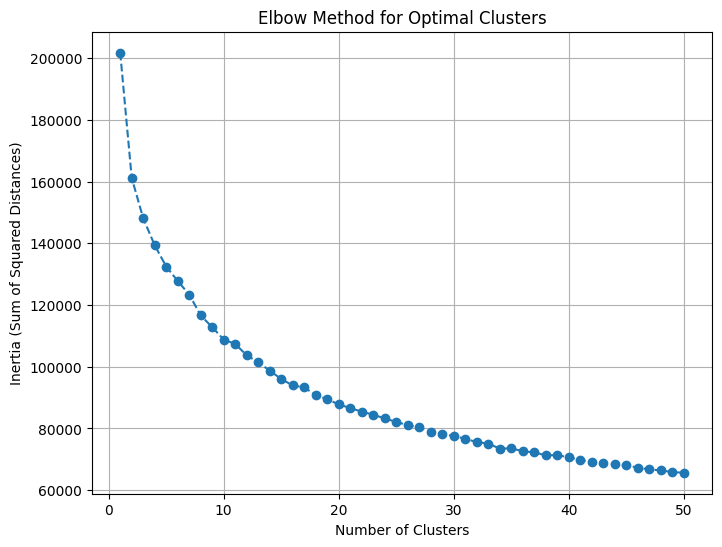

In [66]:
from sklearn.cluster import KMeans

# Find optimal k with Elbow method
def elbow_method(X, max_clusters=50):
    inertia = []
    cluster_range = range(1, max_clusters + 1)
    for k in cluster_range:
        kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
        kmeans.fit(X)
        inertia.append(kmeans.inertia_)
    plt.figure(figsize=(8, 6))
    plt.plot(cluster_range, inertia, marker='o', linestyle='--')
    plt.title('Elbow Method for Optimal Clusters')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia (Sum of Squared Distances)')
    plt.grid(True)
    # plt.savefig('elbow_method_plot.pdf', format='pdf', dpi=300)
    plt.show()

elbow_method(X_train)

R² score for k=1: 0.6982378452336568
R² score for k=2: 0.7160977431446904
R² score for k=3: 0.7144412491067728
R² score for k=4: 0.7089281517445631
R² score for k=5: 0.7214460938410734
R² score for k=6: 0.3706374208519656
R² score for k=7: 0.28802261471333723
R² score for k=8: 0.28380212684364403
R² score for k=9: 0.1640931907826907
R² score for k=10: 0.1653632148454538
R² score for k=11: 0.5418594113211844
R² score for k=12: 0.19772494574067512
R² score for k=13: 0.5613342872989069
R² score for k=14: 0.37629686675342877


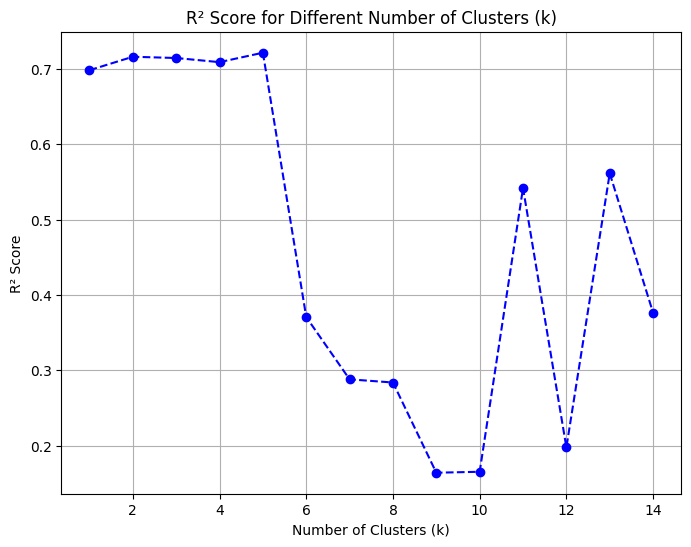

In [68]:
# Define the range of k values for clustering
k_values = range(1, 15, 1)
r2_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_train)
    clusters_train = kmeans.predict(X_train)
    clusters_test = kmeans.predict(X_test)
    
    # Initialize combined prediction array
    y_test_combined = np.zeros_like(y_test)
    cluster_counts = np.zeros_like(y_test, dtype=int)
    
    # Loop over clusters and predict
    for cluster in np.unique(clusters_train):
        X_cluster_train = X_train[clusters_train == cluster]
        y_cluster_train = y_train[clusters_train == cluster]
        X_cluster_test = X_test[clusters_test == cluster]
        
        if len(X_cluster_train) < 2 or len(X_cluster_test) < 1:
            continue  # Skip clusters with insufficient data
        
        # Train model and predict
        model = LinearRegression()
        model.fit(X_cluster_train, y_cluster_train)
        y_pred_cluster = model.predict(X_cluster_test)
        
        # Store predictions and count for averaging
        y_test_combined[clusters_test == cluster] = y_pred_cluster
        cluster_counts[clusters_test == cluster] = 1

    # Ensure there are no missing values in y_test_combined
    if np.any(cluster_counts == 0):
        print(f"Warning: Some test data points not covered by clusters for k={k}. Skipping this k.")
        r2_scores.append(np.nan)
        continue

    # Calculate R² score
    r2 = r2_score(y_test, y_test_combined)
    r2_scores.append(r2)
    print(f"R² score for k={k}: {r2}")

# Plot R² against k values
plt.figure(figsize=(8, 6))
plt.plot(k_values, r2_scores, marker='o', linestyle='--', color='b')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("R² Score")
plt.title("R² Score for Different Number of Clusters (k)")
plt.grid(True)
plt.show()


In [69]:
for cluster in np.unique(clusters_test):
    print(f"Cluster {cluster} - Train size: {sum(clusters_train == cluster)}, Test size: {sum(clusters_test == cluster)}")

Cluster 0 - Train size: 331, Test size: 203
Cluster 1 - Train size: 447, Test size: 98
Cluster 2 - Train size: 703, Test size: 225
Cluster 3 - Train size: 953, Test size: 57
Cluster 4 - Train size: 97, Test size: 23
Cluster 5 - Train size: 703, Test size: 386
Cluster 7 - Train size: 656, Test size: 377
Cluster 8 - Train size: 576, Test size: 220
Cluster 12 - Train size: 715, Test size: 59
Cluster 13 - Train size: 332, Test size: 34


In [47]:
# # Define the range of k values for clustering
# k_values = range(10, 151, 10)
# r2_scores = []
# mse_scores = []

# for k in k_values:
#     kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
#     kmeans.fit(X_train)
#     clusters_train = kmeans.predict(X_train)
#     clusters_test = kmeans.predict(X_test)
    
#     cluster_r2_scores = []
#     cluster_mse_scores = []
    
#     for cluster in np.unique(clusters_train):
#         X_cluster_train = X_train[clusters_train == cluster]
#         y_cluster_train = y_train[clusters_train == cluster]
#         X_cluster_test = X_test[clusters_test == cluster]
#         y_cluster_test = y_test[clusters_test == cluster]
        
#         if len(X_cluster_train) < 2 or len(X_cluster_test) < 1:
#             continue
        
#         model = LinearRegression()
#         model.fit(X_cluster_train, y_cluster_train)
#         y_pred_test = model.predict(X_cluster_test)
        
#         r2 = r2_score(y_cluster_test, y_pred_test)
#         mse = mean_squared_error(y_cluster_test, y_pred_test)
        
#         cluster_r2_scores.append(r2)
#         cluster_mse_scores.append(mse)
    
#     avg_r2 = np.mean(cluster_r2_scores)
#     avg_mse = np.mean(cluster_mse_scores)
#     r2_scores.append(avg_r2)
#     mse_scores.append(avg_mse)

# # Plot R² and MSE against k values
# plt.figure(figsize=(12, 6))
# plt.subplot(1, 2, 1)
# plt.plot(k_values, r2_scores, marker='o', linestyle='--', color='b')
# plt.xlabel("Number of Clusters (k)")
# plt.ylabel("Average R² Score")
# plt.title("Impact of Number of Clusters on R² Score")
# plt.grid(True)

# plt.subplot(1, 2, 2)
# plt.plot(k_values, mse_scores, marker='o', linestyle='--', color='r')
# plt.xlabel("Number of Clusters (k)")
# plt.ylabel("Average MSE")
# plt.title("Impact of Number of Clusters on MSE")
# plt.grid(True)
# plt.tight_layout()
# plt.show()


In [48]:
# # Optimal clustering
# optimal_clusters = 4  # Change based on elbow method results
# kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
# clusters = kmeans.fit_predict(X_train_scaled)

# # Regression per cluster
# def apply_regression_to_clusters(X, y, clusters):
#     results = []
#     for cluster in np.unique(clusters):
#         X_cluster = X[clusters == cluster]
#         y_cluster = y[clusters == cluster]
        
#         if np.isnan(X_cluster).any() or np.isnan(y_cluster).any():
#             print(f"Skipping cluster {cluster} due to NaN values.")
#             continue
        
#         cluster_results = {'Cluster': cluster}
        
#         # Gradient Descent Linear Regression
#         try:
#             gd_model = LinearRegression()  # Use LinearRegression or LinearRegressionGD if available
#             gd_model.fit(X_cluster, y_cluster)
#             y_pred_gd = gd_model.predict(X_cluster)
#             rmse_gd = np.sqrt(mean_squared_error(y_cluster, y_pred_gd))
#             r2_gd = r2_score(y_cluster, y_pred_gd)
#             cluster_results['Gradient Descent RMSE'] = rmse_gd
#             cluster_results['Gradient Descent R2'] = r2_gd
#         except Exception as e:
#             print(f"Error in Gradient Descent for cluster {cluster}: {e}")
            
#          # Closed form solution
#         try:
#             theta_best = closed_form_solution(X_cluster, y_cluster)
#             X_b = np.c_[np.ones((X_cluster.shape[0], 1)), X_cluster]
#             y_pred_closed_form = X_b.dot(theta_best)
#             rmse_closed = np.sqrt(mean_squared_error(y_cluster, y_pred_closed_form))
#             r2_closed = r2_score(y_cluster, y_pred_closed_form)
#             cluster_results['Closed Form RMSE'] = rmse_closed
#             cluster_results['Closed Form R2'] = r2_closed
#         except Exception as e:
#             print(f"Error in Closed Form Solution for cluster {cluster}: {e}")
            
#         # Polynomial Regression (Degree 2)
#         try:
#             poly_features = PolynomialFeatures(degree=2, include_bias=False)
#             X_cluster_poly = poly_features.fit_transform(X_cluster)
#             poly_model = LinearRegression()  # Use Polynomial regression model if available
#             poly_model.fit(X_cluster_poly, y_cluster)
#             y_pred_poly = poly_model.predict(X_cluster_poly)
#             rmse_poly = np.sqrt(mean_squared_error(y_cluster, y_pred_poly))
#             r2_poly = r2_score(y_cluster, y_pred_poly)
#             cluster_results['Polynomial RMSE'] = rmse_poly
#             cluster_results['Polynomial R2'] = r2_poly
#         except Exception as e:
#             print(f"Error in Polynomial Regression for cluster {cluster}: {e}")
        
#         results.append(cluster_results)
    
#     results_df = pd.DataFrame(results)
#     return results_df

# results_df = apply_regression_to_clusters(X_train_scaled, y_train, clusters)
# print(results_df)


## Step 7: k-means Clustering (Simon)

# Model 2

## Step 1: Data Selection + Handling

In [49]:
# Load the data
# Forecast (Solar + Onshore Wind + Offshore Wind)
FC_SolarWind = pd.read_csv('New Data/2021/Forecasts_SolarWind.csv', delimiter=';')
# Filter data for DK2
FC_SolarWind = FC_SolarWind[FC_SolarWind['PriceArea'] == 'DK2']
# Keep only the HourUTC, ForecastType, ForecastDayAhead columns
FC_SolarWind = FC_SolarWind[['HourUTC', 'ForecastType', 'ForecastDayAhead']]
# Rename the column HourUTC to ts
FC_SolarWind.rename(columns={'HourUTC': 'ts'}, inplace=True)
# Pivot the data?
FC_SolarWind = FC_SolarWind.pivot(index='ts', columns='ForecastType', values='ForecastDayAhead')
FC_SolarWind.columns = [f"FC_{col.replace(' ', '')}" for col in FC_SolarWind.columns]
# Reset index
FC_SolarWind = FC_SolarWind.reset_index()
# Convert ts to datetime
FC_SolarWind['ts'] = pd.to_datetime(FC_SolarWind['ts'])

# Forecast (Electricity Consumption)
FC_Tennet = pd.read_csv('New Data/2021/Forecast_PowerConsumption_TenneT.csv', delimiter=';') 
FC_50Hertz = pd.read_csv('New Data/2021/Forecast_PowerConsumption_50Hertz.csv', delimiter=';')

# Rename Datum von to ts
FC_Tennet.rename(columns={'Datum von': 'ts'}, inplace=True)
FC_50Hertz.rename(columns={'Datum von': 'ts'}, inplace=True)
# Drop Datum bis column
FC_Tennet.drop(columns=['Datum bis'], inplace=True)
FC_50Hertz.drop(columns=['Datum bis'], inplace=True)
# Rename Gesamt (Netzlast) [MWh] Berechnete Auflösungen to FC_NetLoad
FC_Tennet.rename(columns={'Gesamt (Netzlast) [MWh] Berechnete Auflösungen': 'FC_NetLoad'}, inplace=True)
FC_50Hertz.rename(columns={'Gesamt (Netzlast) [MWh] Berechnete Auflösungen': 'FC_NetLoad'}, inplace=True)
# Rename Residuallast [MWh] Berechnete Auflösungen to FC_ResidualLoad
FC_Tennet.rename(columns={'Residuallast [MWh] Berechnete Auflösungen': 'FC_ResidualLoad'}, inplace=True)
FC_50Hertz.rename(columns={'Residuallast [MWh] Berechnete Auflösungen': 'FC_ResidualLoad'}, inplace=True)

# Convert ts to datetime
FC_Tennet['ts'] = pd.to_datetime(FC_Tennet['ts'], format='%d.%m.%Y %H:%M')
FC_50Hertz['ts'] = pd.to_datetime(FC_50Hertz['ts'], format='%d.%m.%Y %H:%M')

# Filter for the specified date range
FC_SolarWind_filtered = FC_SolarWind[(FC_SolarWind['ts'] >= start) & (FC_SolarWind['ts'] <= end)]
FC_Tennet_filtered = FC_Tennet[(FC_Tennet['ts'] >= start) & (FC_Tennet['ts'] <= end)]
FC_50Hertz_filtered = FC_50Hertz[(FC_50Hertz['ts'] >= start) & (FC_50Hertz['ts'] <= end)]

# Reset index
FC_SolarWind_filtered.reset_index(drop=True, inplace=True)
FC_Tennet_filtered.reset_index(drop=True, inplace=True)
FC_50Hertz_filtered.reset_index(drop=True, inplace=True)

# Shape
print("Solar and Wind Forecast:",FC_SolarWind_filtered.shape)
print("Electricit Consumption Forecast (Tennet):", FC_Tennet_filtered.shape)
print("Electricit Consumption Forecast (50Hertz):", FC_50Hertz_filtered.shape)
print("Shape of data:", data.shape)

Solar and Wind Forecast: (8407, 4)
Electricit Consumption Forecast (Tennet): (8408, 3)
Electricit Consumption Forecast (50Hertz): (8408, 3)
Shape of data: (8408, 33)


In [50]:
# Check shape difference
ts1 = set(FC_SolarWind_filtered['ts'])
ts2 = set(FC_Tennet_filtered['ts'])
ts3 = set(FC_50Hertz_filtered['ts'])
ts4 = set(data['ts'])

symmetric_diff = ts1.symmetric_difference(ts4)
print("Values in 'ts' that are different between df1 and data:", symmetric_diff)
symmetric_diff2 = ts2.symmetric_difference(ts4)
print("Values in 'ts' that are different between df2 and data:", symmetric_diff2)
symmetric_diff3 = ts3.symmetric_difference(ts4)
print("Values in 'ts' that are different between df3 and data:", symmetric_diff3)

Values in 'ts' that are different between df1 and data: {Timestamp('2021-10-07 22:00:00')}
Values in 'ts' that are different between df2 and data: {Timestamp('2021-03-28 02:00:00')}
Values in 'ts' that are different between df3 and data: {Timestamp('2021-03-28 02:00:00')}


## Step 2: Regression Model

## Step 3: Comparison (Model 1 vs. Model 2)

## Appendix / Archive

Implementation of Linear + Polynomial Regression with Regularization

In [191]:
# from sklearn.base import BaseEstimator, RegressorMixin

# class LinearRegressionWithRegularization(BaseEstimator, RegressorMixin):
#     def __init__(self, learning_rate=0.01, n_iterations=1000, alpha=0.1, regularization="l1"):
#         # Hyperparameters
#         self.learning_rate = learning_rate
#         self.n_iterations = n_iterations
#         self.alpha = alpha  # Regularization strength
#         self.regularization = regularization
#         self.theta = None  # Parameters (weights and bias)

#     def fit(self, X, y):
#         # Ensure X and y are NumPy arrays
#         X = np.array(X, dtype=float)
#         y = np.array(y, dtype=float)

#         # Add a bias (intercept) column of ones to the input matrix X
#         X_b = np.c_[np.ones((X.shape[0], 1)), X]  # X_b now includes the bias term
#         m, n = X_b.shape

#         # Initialize theta
#         self.theta = np.zeros(n)

#         # Gradient Descent loop
#         for _ in range(self.n_iterations):
#             # Predicted values (y_hat = X_b * theta)
#             y_pred = X_b.dot(self.theta)

#             # Compute the gradient
#             gradient = (1 / m) * X_b.T.dot(y_pred - y)

#             # Apply regularization to the gradient (skip bias term)
#             if self.regularization == "l2":
#                 # L2 Regularization (Ridge): (MSE + L2 penalty)
#                 gradient[1:] += 2 * self.alpha * self.theta[1:]
#             elif self.regularization == "l1":
#                 # L1 Regularization (LASSO): (MSE + L1 penalty)
#                 for j in range(1, n):
#                     if self.theta[j] > 0:
#                         gradient[j] += self.alpha
#                     elif self.theta[j] < 0:
#                         gradient[j] -= self.alpha

#             # Update parameters
#             self.theta -= self.learning_rate * gradient

#     def predict(self, X):
#         # Ensure X is a NumPy array and convert it to float type
#         X = np.array(X, dtype=float)

#         # Add a bias (intercept) column of ones to the input matrix X
#         X_b = np.c_[np.ones((X.shape[0], 1)), X]

#         # Return predictions (y_pred = X_b * theta)
#         return X_b.dot(self.theta)

In [192]:
# # Test model for L1 (LASSO)
# model_l1 = LinearRegressionWithRegularization(alpha=0.05, regularization="l1")
# model_l1.fit(X_train, y_train)
# y_pred_l1 = model_l1.predict(X_test)

# # Evaluate L1 model
# r2_l1 = r2_score(y_test, y_pred_l1)
# print(f"R-squared (Lasso): {r2_l1}")

# # Test model for L2 (RIDGE)
# model_l2 = LinearRegressionWithRegularization(alpha=0.05, regularization="l2")
# model_l2.fit(X_train, y_train)
# y_pred_l2 = model_l2.predict(X_test)

# # Evaluate L2 model
# r2_l2 = r2_score(y_test, y_pred_l2)
# print(f"R-squared (Ridge): {r2_l2}")

# # Convert predictions to pandas Series with y_test's original index
# y_pred_l1 = pd.Series(y_pred_l1, index=y_test.index)
# y_pred_l2 = pd.Series(y_pred_l2, index=y_test.index)

In [193]:
# # Initialize the model
# model_lasso = LinearRegressionWithRegularization(regularization="l1", learning_rate=0.001, n_iterations=10000)
# # Define a range of alpha values to test
# alpha_values = np.logspace(-4, 0, num=20)
# param_grid = {'alpha': alpha_values}

# # Set up the Lasso model with CV
# grid_search = GridSearchCV(estimator=model_lasso, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
# grid_search.fit(X_train, y_train)

# # Get the best alpha
# best_alpha = grid_search.best_params_['alpha']
# print(f"Optimal Alpha: {best_alpha}")

# # Best model after grid search
# best_model = grid_search.best_estimator_
# y_pred_l1 = best_model.predict(X_test)

# # Evaluate the model
# r2_l1 = r2_score(y_test, y_pred_l1)

# # Coefficients
# print("#Lasso Coefficients != 0:", np.sum(best_model.theta != 0))
# cols = ['Intercept'] + list(X_train.columns)
# lasso_coefficients_df = pd.DataFrame({ 'Feature': cols, 'Coefficient': best_model.theta})
# lasso_coefficients_df = lasso_coefficients_df[lasso_coefficients_df['Coefficient'] != 0] # Filter non-zeros
# lasso_coefficients_df.T

In [194]:
# # Step 5.5: Analyze how regularization affects Lasso coefficients

# # Train baseline Linear Regression for coefficient comparison
# linear_model = LinearRegression()
# linear_model.fit(X_train, y_train)
# baseline_coefs = pd.Series(linear_model.coef_, index=X_train.columns, name="Baseline Linear Regression Coefs")

# # Compare baseline vs Lasso coefficients
# lasso_coefs = pd.Series(lasso3.coef_, index=X_train.columns, name="Lasso Coefs (Optimal Alpha)")
# lasso_comparison = pd.concat([baseline_coefs, lasso_coefs], axis=1)
# lasso_comparison['Change (Lasso)'] = lasso_comparison['Lasso Coefs (Optimal Alpha)'] - lasso_comparison['Baseline Linear Regression Coefs']

# print("Lasso Coefficients Comparison (showing features shrunk by regularization):")
# print(lasso_comparison[lasso_comparison['Lasso Coefs (Optimal Alpha)'] == 0])  # Features set to zero by Lasso
# print("\nTop features with significant change under Lasso regularization:")
# print(lasso_comparison[lasso_comparison['Change (Lasso)'].abs() > 0.1])  # Adjust threshold based on feature scale


In [195]:
# class PolynomialRegressionWithRegularization(BaseEstimator, RegressorMixin):
#     def __init__(self, degree, learning_rate=0.01, n_iterations=1000, alpha=0.1, regularization="l1"):
#         # Hyperparameters
#         self.degree = degree
#         self.learning_rate = learning_rate
#         self.n_iterations = n_iterations
#         self.alpha = alpha # = Regularization strength
#         self.regularization = regularization
#         self.theta = None

#     def _polynomial_features(self, X):
#         # Generate polynomial features up to specified degree
#         X_poly = np.ones((X.shape[0], 1)) # Bias term
#         for d in range(1, self.degree + 1):
#             X_poly = np.c_[X_poly, X ** d]
#         return X_poly

#     # Gradient Descent Fit
#     def fit(self, X, y):
#         # Generate polynomial features
#         X_poly = self._polynomial_features(X)
#         # Number of training samples (m) and number of features (n)
#         m, n = X_poly.shape
#         # Initialize theta
#         self.theta = np.zeros(n)
        
#         # Gradient Descent loop
#         for _ in range(self.n_iterations):
#             # Predicted values (y_hat = X_b * theta)
#             y_pred = X_poly.dot(self.theta)
            
#             # Compute the gradient
#             gradient = (1 / m) * X_poly.T.dot(y_pred - y)
            
#             # Apply regularization to the gradient (& skip bias term)
#             if self.regularization == "l2":
#                 # L2 Regularization (Ridge): (MSE + L2 penalty)
#                 gradient[1:] += 2 * self.alpha * self.theta[1:]
#             elif self.regularization == "l1":
#                 # L1 Regularization (LASSO): (MSE + L1 penalty)
#                 for j in range(1, n):
#                     if self.theta[j] > 0:
#                         gradient[j] += self.alpha
#                     elif self.theta[j] < 0:
#                         gradient[j] -= self.alpha
            
#             # Update parameters
#             self.theta -= self.learning_rate * gradient
    
#     def predict(self, X):
#         # Generate polynomial features (including bias term)
#         X_poly = self._polynomial_features(X)
        
#         # Return predictions
#         return X_poly.dot(self.theta)

In [196]:
# # Test model for L1 (LASSO)
# model_nl1 = PolynomialRegressionWithRegularization(degree=2, alpha=0.05, learning_rate=0.001, n_iterations=10000, regularization="l1")
# model_nl1.fit(X_train, y_train)
# y_pred_nl1 = model_nl1.predict(X_test)

# # Evaluate L1 model
# r2_nl1 = r2_score(y_test, y_pred_nl1)
# print(f"R-squared (Lasso): {r2_nl1}")

# # Test model for L2 (RIDGE)
# model_nl2 = PolynomialRegressionWithRegularization(degree=2, alpha=0.05, learning_rate=0.001, n_iterations=10000, regularization="l2")
# model_nl2.fit(X_train, y_train)
# y_pred_nl2 = model_nl2.predict(X_test)

# # Evaluate L2 model
# r2_nl2 = r2_score(y_test, y_pred_nl2)
# print(f"R-squared (Ridge): {r2_nl2}")

# # Convert predictions to pandas Series with y_test's original index
# y_pred_nl1 = pd.Series(y_pred_nl1, index=y_test.index)
# y_pred_nl2 = pd.Series(y_pred_nl2, index=y_test.index)